In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm

In [2]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [13]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters


def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    result = od(sorted(result.items(), key=lambda x: x[0]))

    return {"S": result, "L": heat["L"], "D": heat["D"]}


def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1]),
            "stitched": stitch_S(tpl[1], tpl[0])
        }

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [7]:
L_list = [8, 12, 16, 20, 24, 32, 48, 64, 96]
[l * l for l in L_list]

[64, 144, 256, 400, 576, 1024, 2304, 4096, 9216]

In [14]:
L = 8
D = 0
R = 32768 if L == 96 else 131072
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}]

parameters = []
for x in zip(cool, heat):
    parameters.append(read_tuple_files(x))

#plot S and culling factor

plt.figure(figsize=(16, 9))

cool, heat, st = parameters[0]['cool'], parameters[0]['heat'], parameters[0]['stitched']

plt.plot([x for x in st['S']], [y for x, y in st['S'].items()], 'o')
plt.grid()
plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
plt.ylabel('$S(E)$', fontsize=16)
plt.xlabel('$E$', fontsize=16)
#savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
#plt.show()

plt.figure(figsize=(16, 9))

plt.plot([x for x in cool['culling_factor']], [y for x, y in cool['culling_factor'].items()], 'o')
plt.plot([x for x in heat['culling_factor']], [y for x, y in heat['culling_factor'].items()], 'o')
plt.grid()

plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
plt.ylabel('$culling\_factor(E)$', fontsize=16)
plt.xlabel('$E$', fontsize=16)
#plt.show()
#plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [29]:
#for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.87, 1.9, 1.92, 1.95, 1.962, 1.99], desc="D"):

In [34]:
L_list = [8, 12, 16, 20, 24, 32, 48]
R_list = [#32768 if L == 96 else
    131072 for L in L_list]
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
} for L, R in zip(L_list, R_list)], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
} for L, R in zip(L_list, R_list)]

#print(D)
parameters = []
for x in zip(cool, heat):
    parameters.append(read_tuple_files(x))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


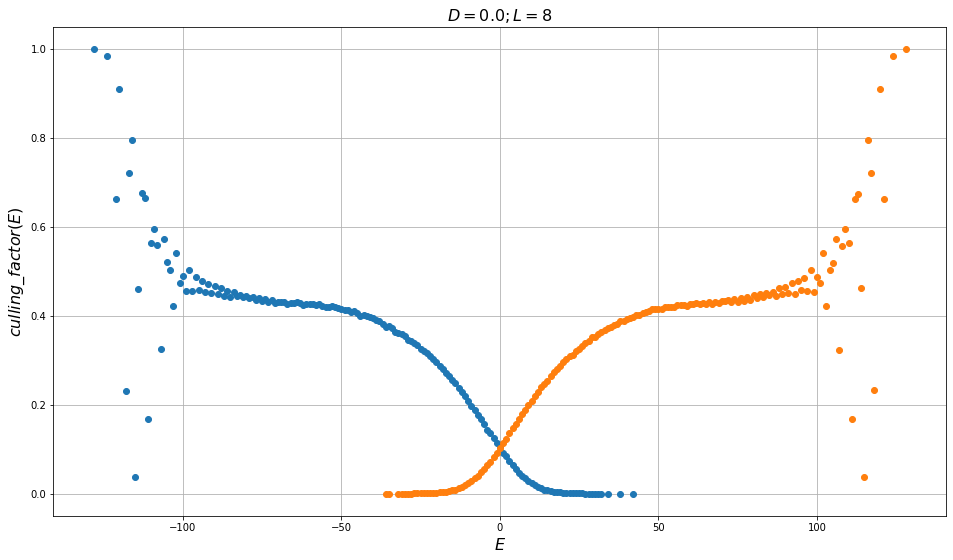

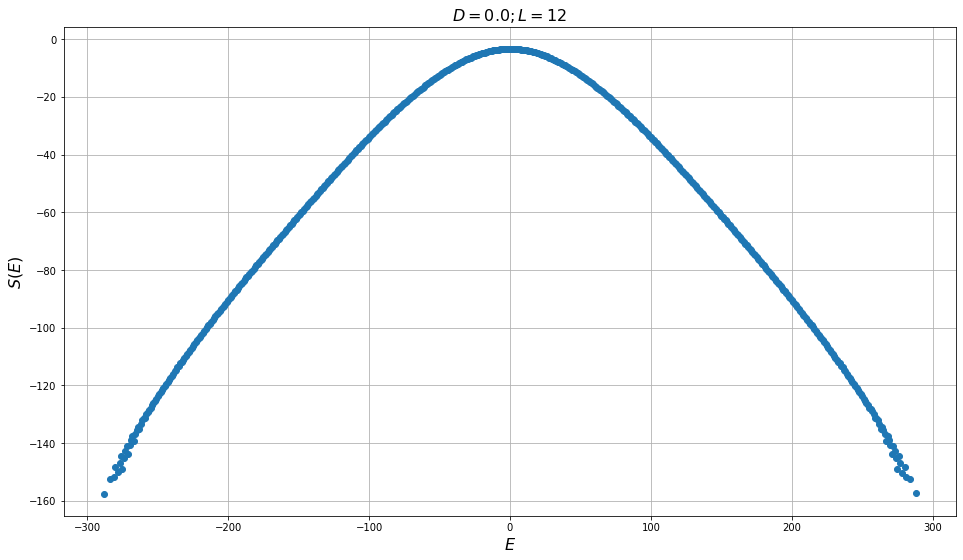

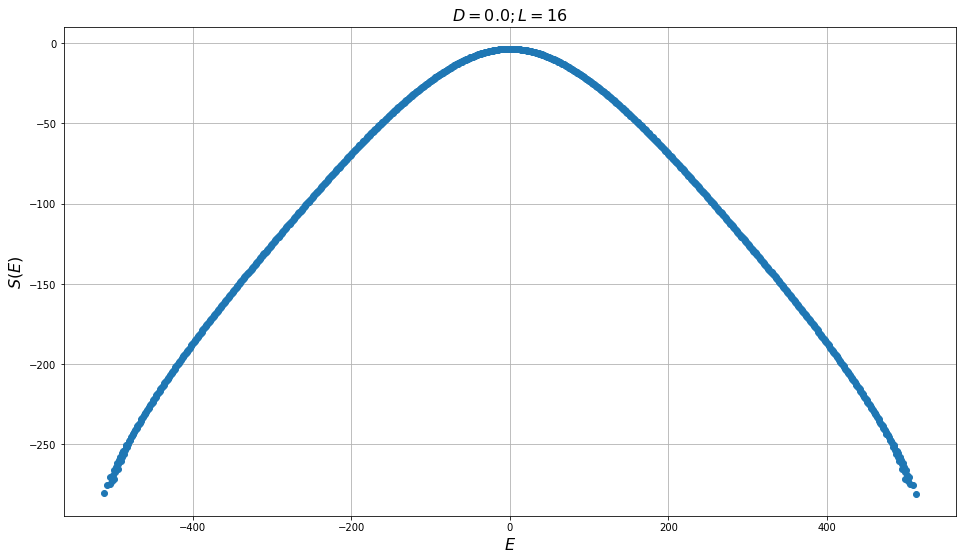

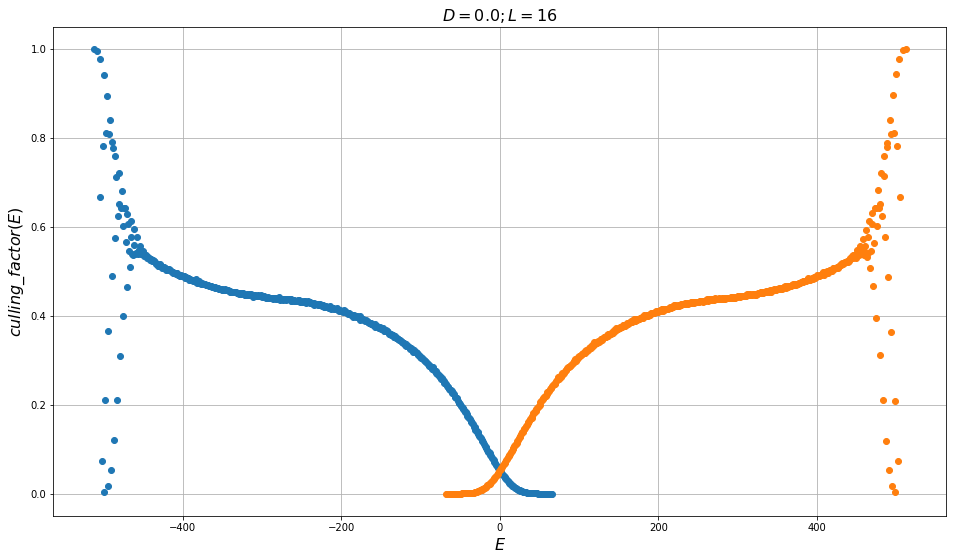

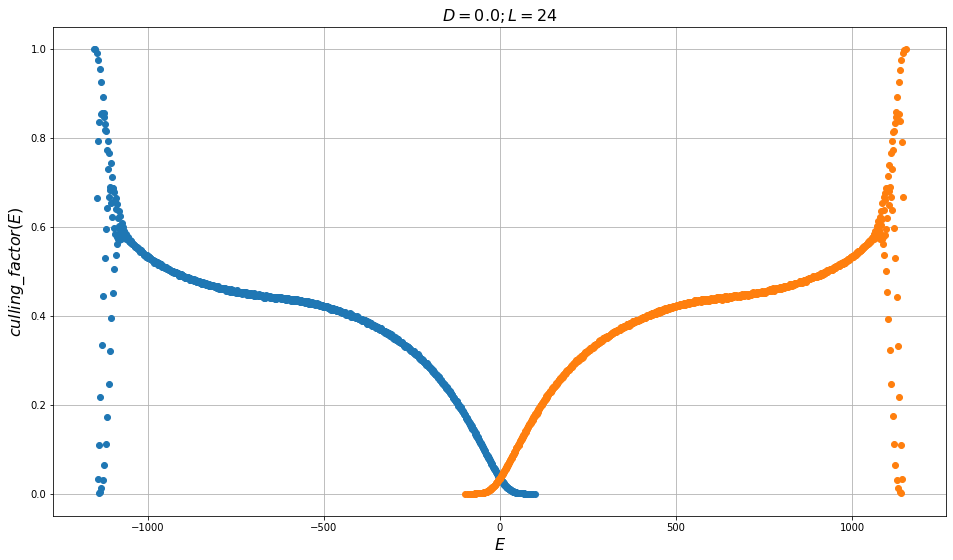

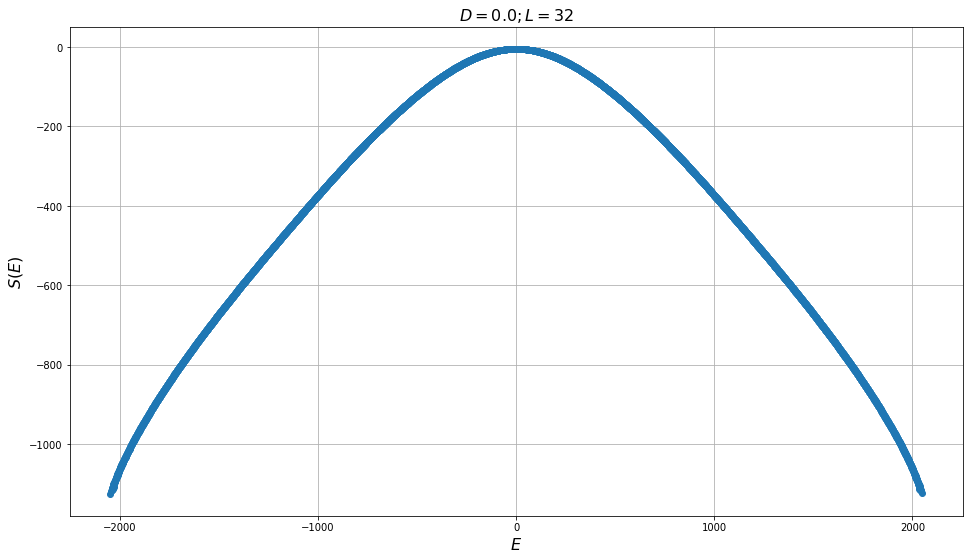

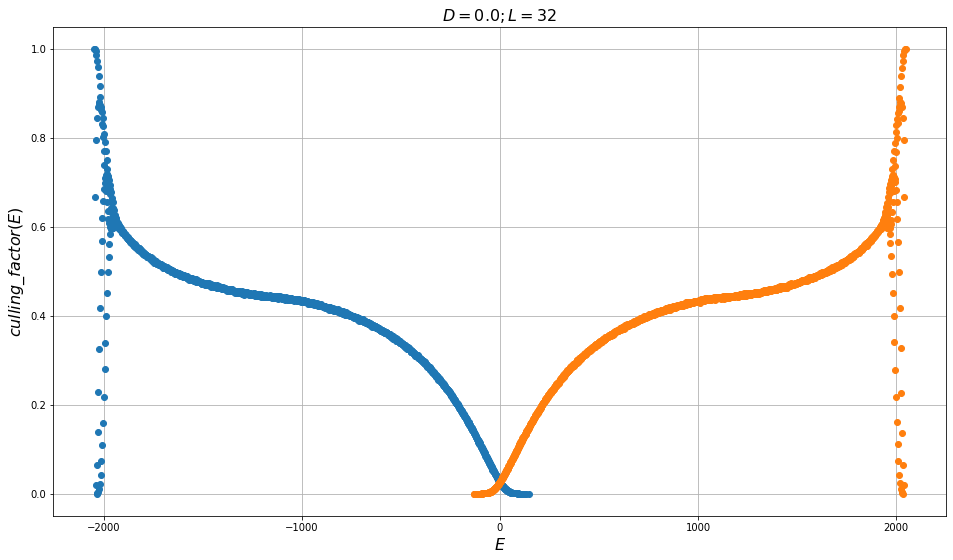

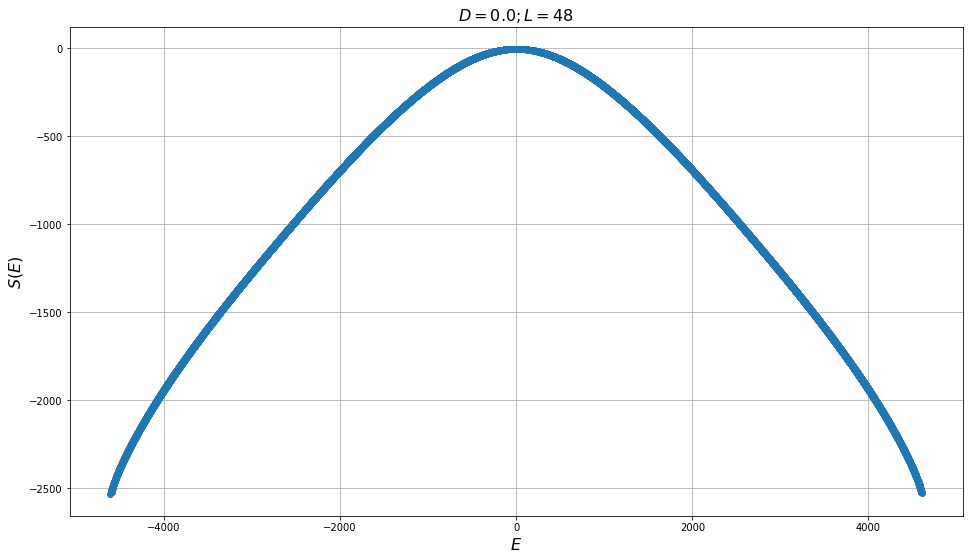

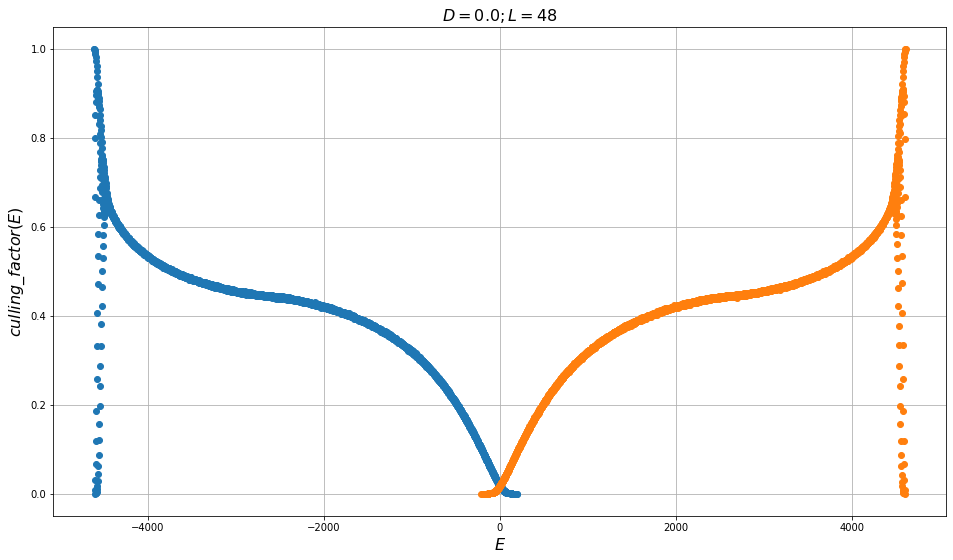

In [35]:
#plot S and culling factor
for i, x in enumerate(tqdm(parameters, desc="L")):
    cool, heat, st = x['cool'], x['heat'], x['stitched']

    plt.figure(figsize=(16, 9))

    plt.plot([E for E in st['S']], [S for E, S in st['S'].items()], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$S(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    plt.savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
    #plt.show()

    plt.figure(figsize=(16, 9))

    plt.plot([E for E in cool['culling_factor']], [c for E, c in cool['culling_factor'].items()], 'o')
    plt.plot([E for E in heat['culling_factor']], [c for E, c in heat['culling_factor'].items()], 'o')
    plt.grid()

    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$culling\_factor(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    plt.savefig("./images/culling_factor(E)_D{}_L{}.png".format(st["D"], st["L"]))
    #plt.show()


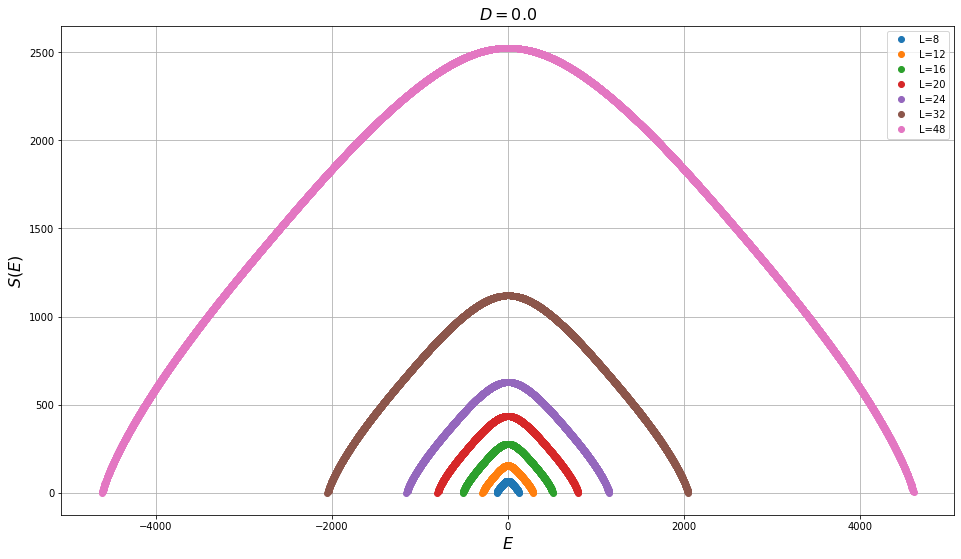

In [40]:
#plot co-plots of different L: S
#print(D)
plt.figure(figsize=(16, 9))
for i, x in enumerate(parameters):
    cool, heat, st = x['cool'], x['heat'], x['stitched']
    S_level = min(S for E, S in st['S'].items())
    plt.plot([E for E in st['S']], [S - S_level for E, S in st['S'].items()], 'o', label='L={}'.format(st["L"]))


plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$S(E)$', fontsize=16)
plt.xlabel('$E$', fontsize=16)
plt.legend()
plt.savefig("./images/S(E)_D{}.png".format(st["D"]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


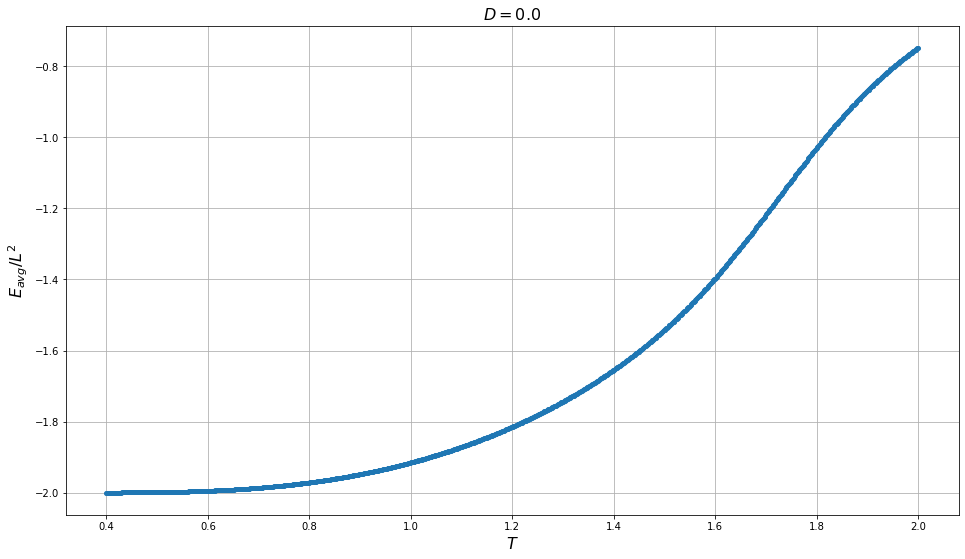

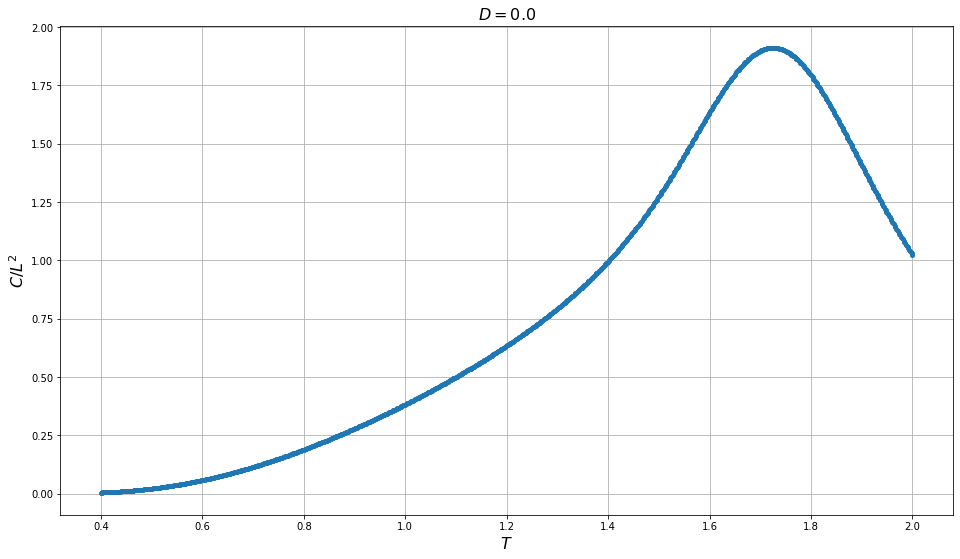

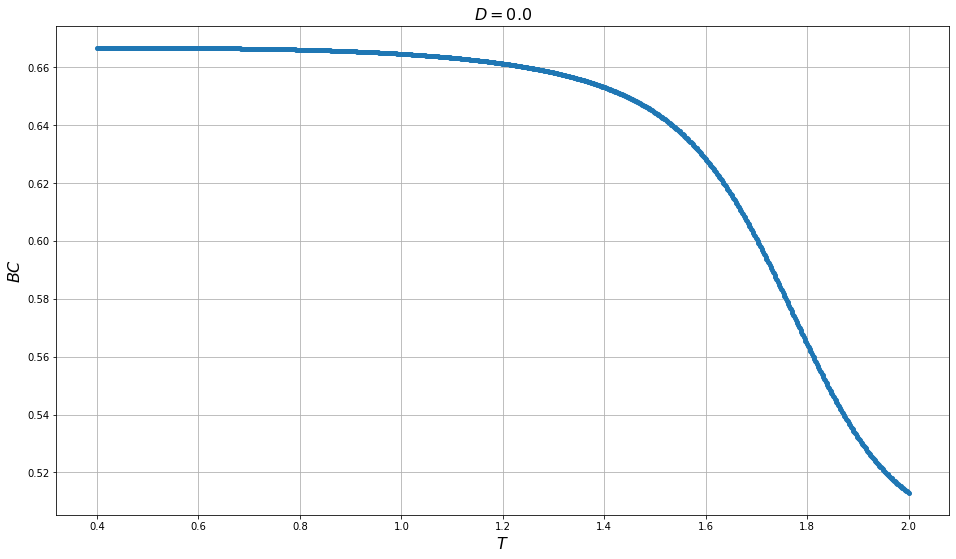

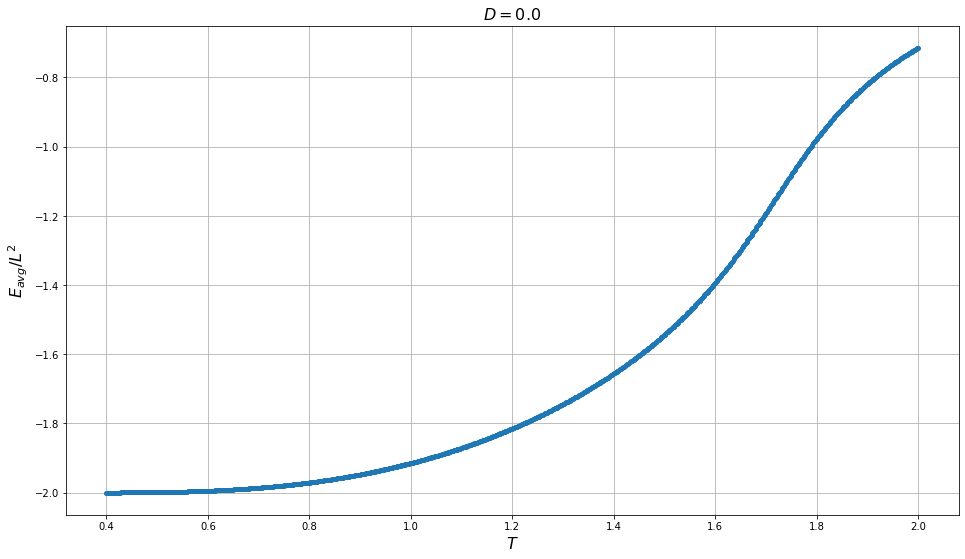

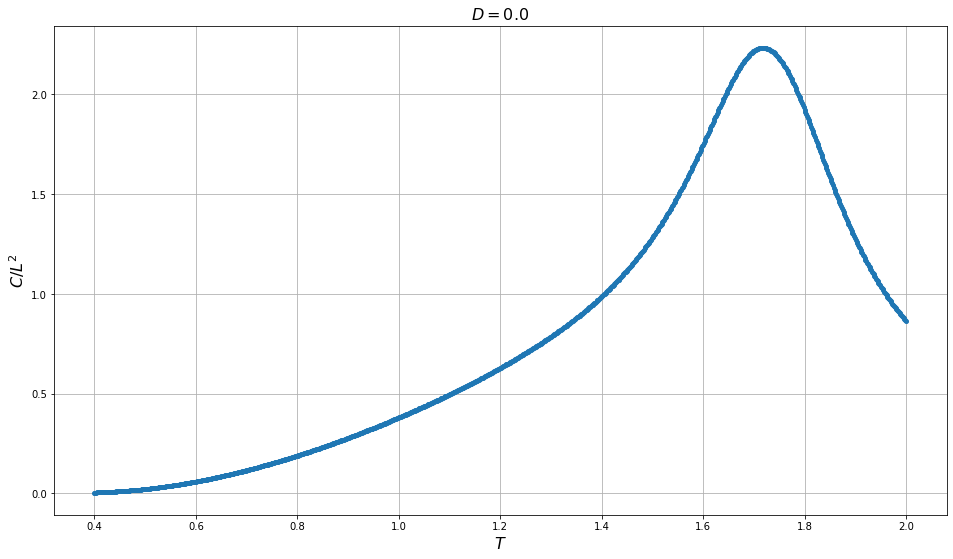

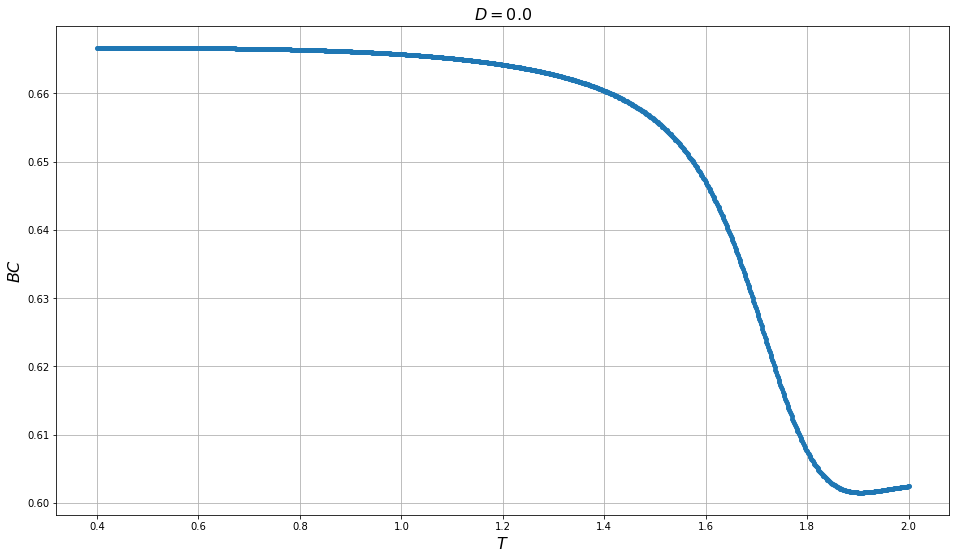

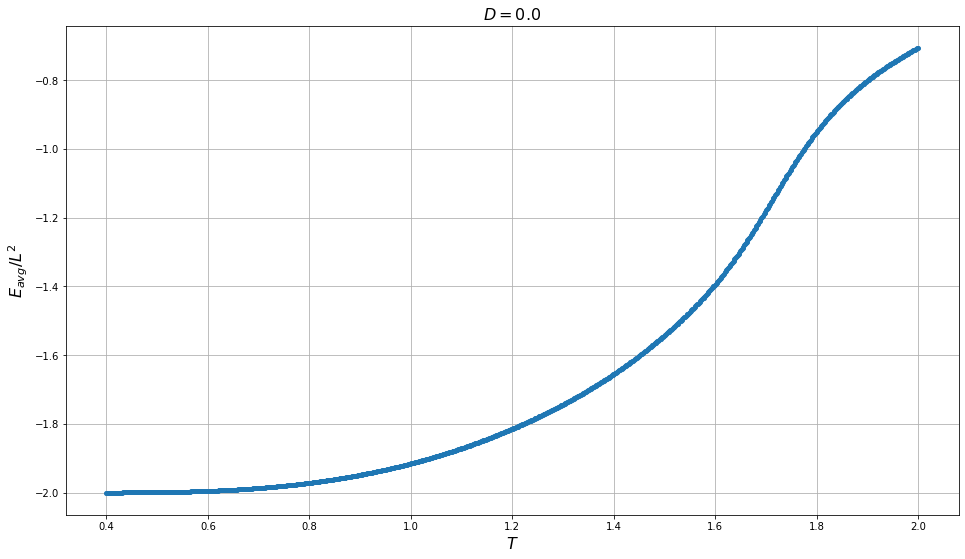

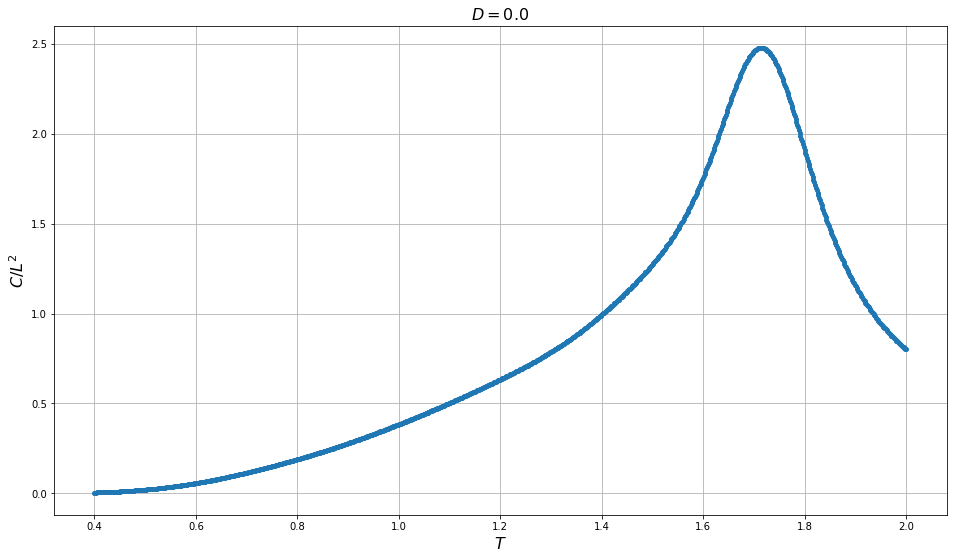

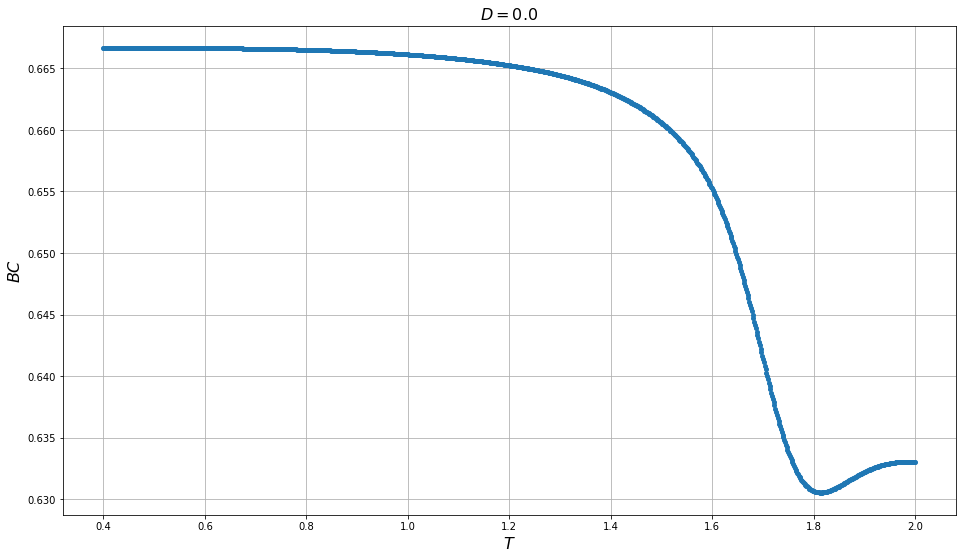

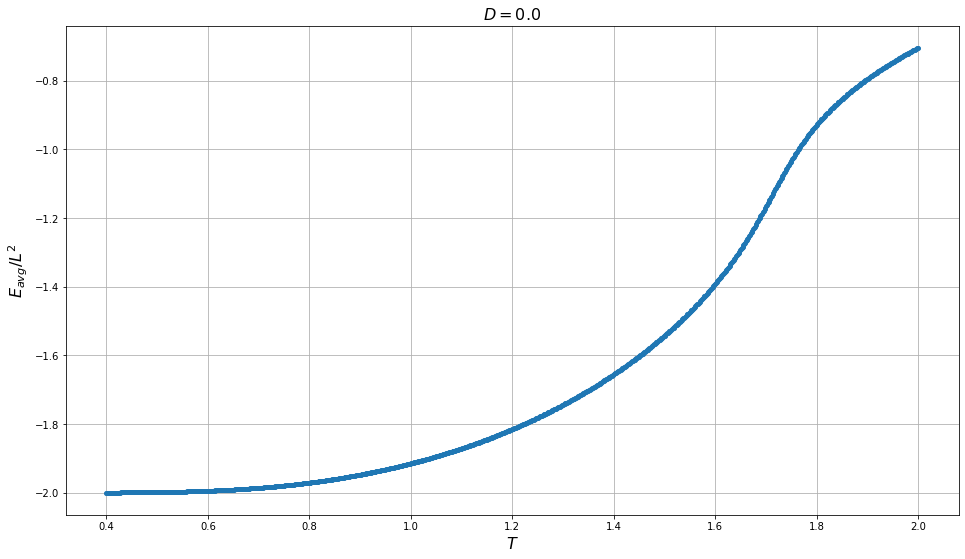

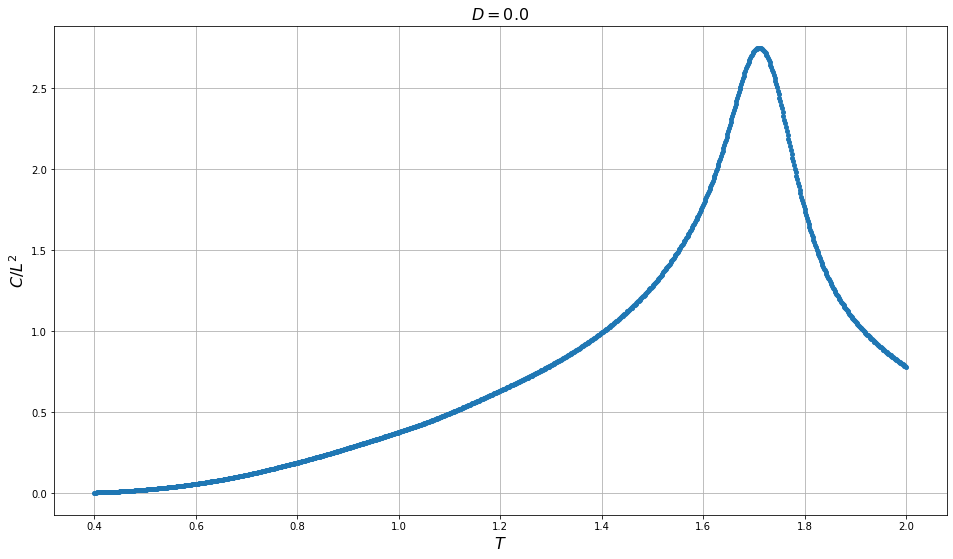

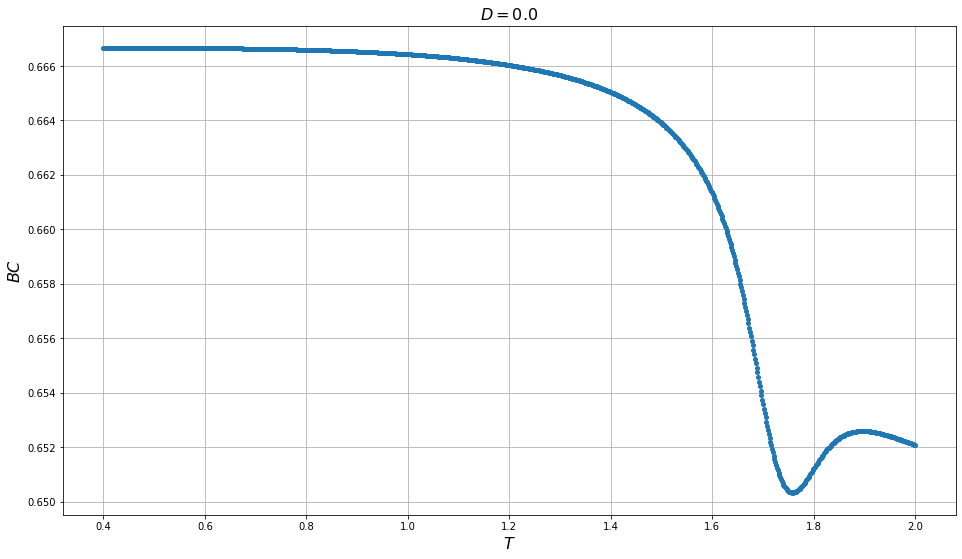

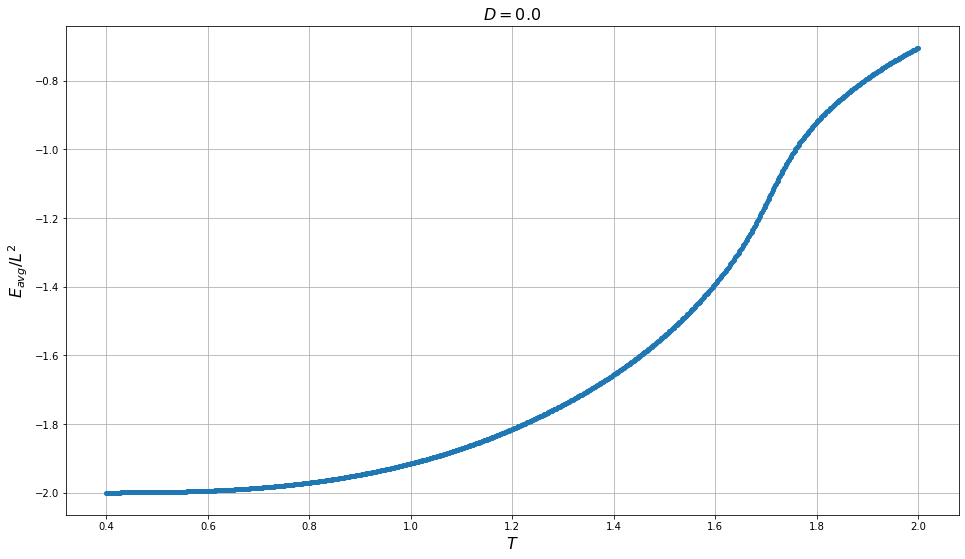

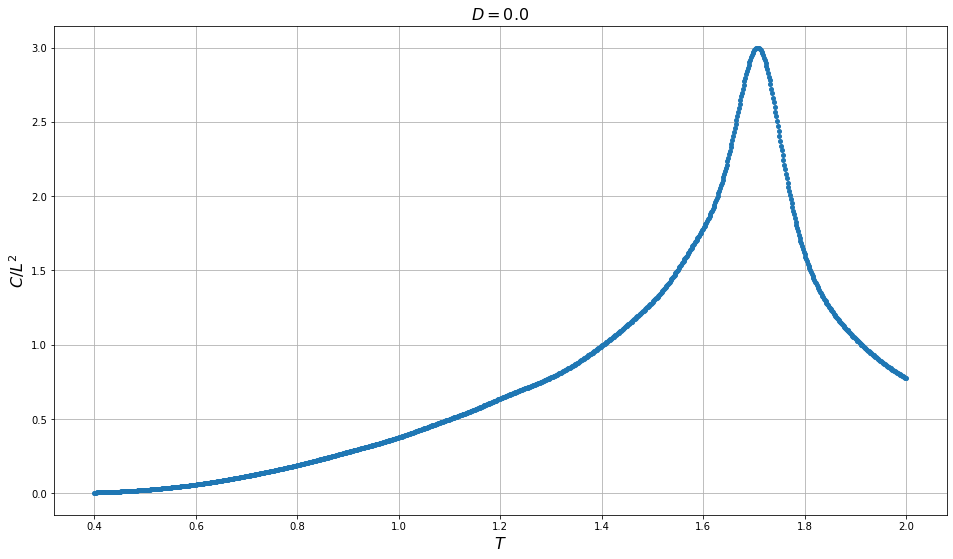

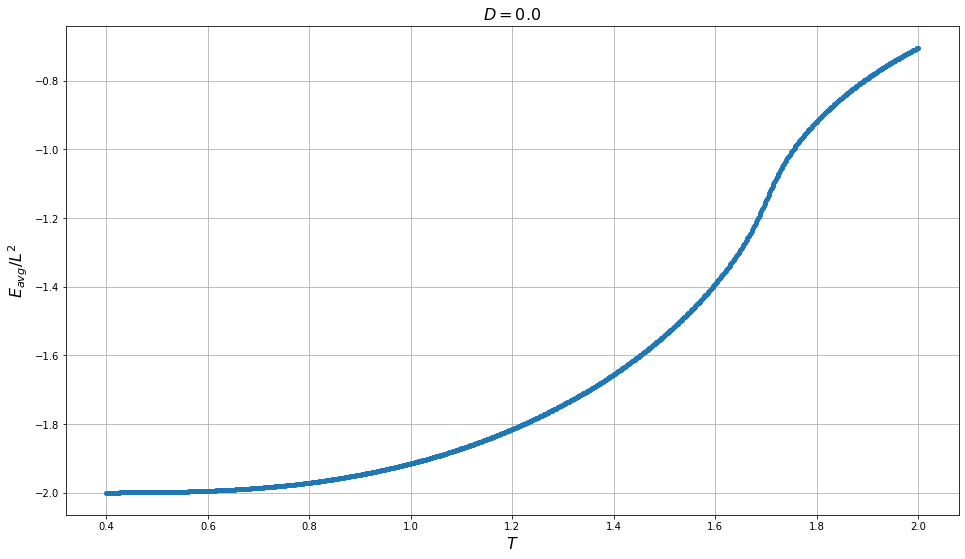

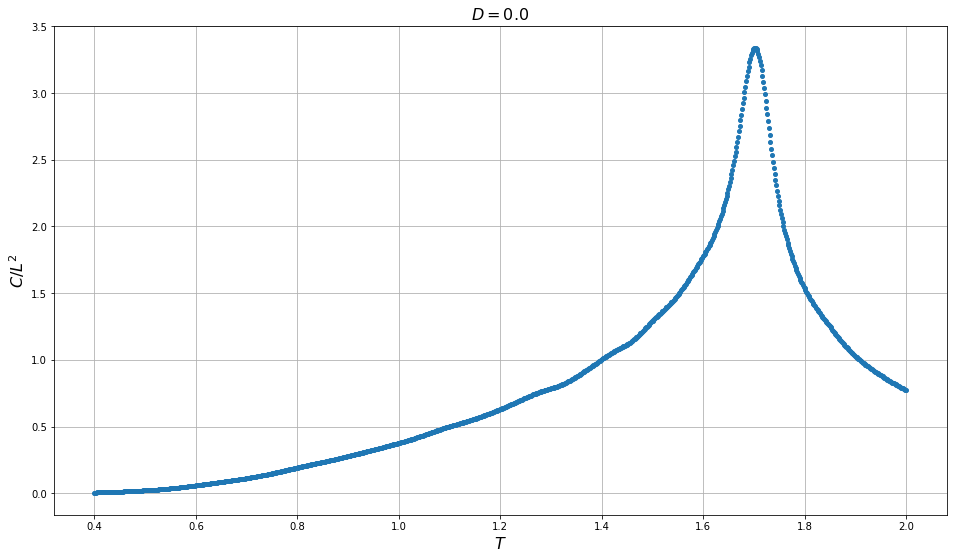

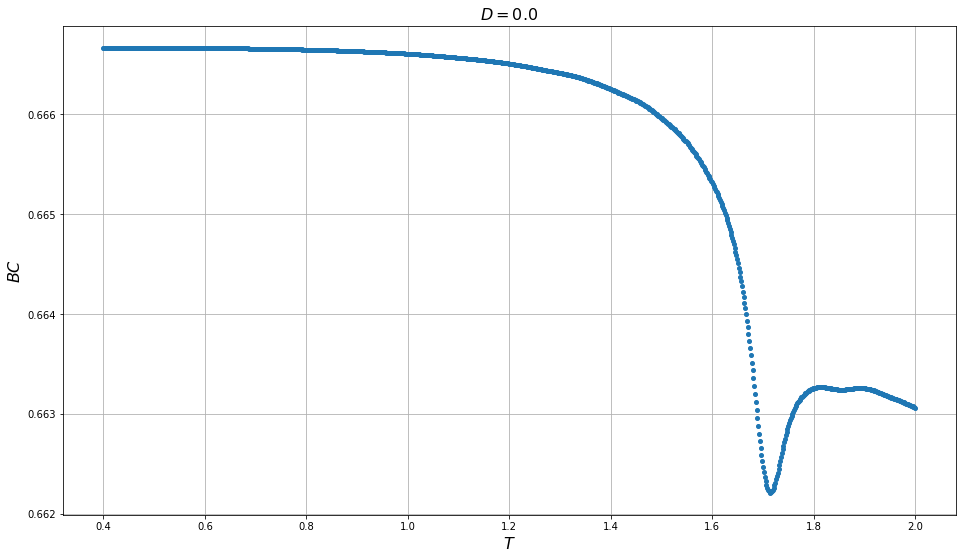

In [42]:
#plot heat capacity, E_avg and Binder Cummulant

hc = {}
E = {}
BC = {}

for i, x in enumerate(tqdm(parameters, desc='over parameters')):
    st = parameters[i]["stitched"]
    L = st['L']
    N = L * L

    hc[L] = {}
    E[L] = {}
    BC[L] = {}


    #frames_list = list(zip(itertools.repeat(st), np.linspace(0.4, 2.0, 1000)))
    #with Pool(6) as p:
    #    pool_outputs = list(
    #            p.map(calc_hc_tpl, tqdm(frames_list, total=len(frames_list)))
    #    )

    # T, C, average E, BinderCumulant
    #for tpl in pool_outputs:
    #    T, x, y, z = tpl
    #    hc[L][T], E[L][T], BC[L][T] = x, y, z
    for T in tqdm(np.linspace(0.4, 2.0, 1000), desc='over temperature'):
        #T, C, average E, BinderCumulant
        _, hc[L][T], E[L][T], BC[L][T] = calc_hc(st, T)

    plt.figure(figsize=(16, 9))

    plt.plot([float(T) for T in E[st["L"]]], [float(E) / (L * L) for T, E in E[st["L"]].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$E_{avg} / L^2$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.savefig("./images/E_avg(T)_D{}_L{}.png".format(st["D"], st["L"]))


    plt.figure(figsize=(16, 9))

    plt.plot([float(T) for T in hc[st["L"]]], [float(C) / (L * L) for T, C in hc[st["L"]].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$C / L^2$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.savefig("./images/C(T)_D{}_L{}.png".format(st["D"], st["L"]))

    plt.figure(figsize=(16, 9))

    plt.plot([float(T) for T in BC[st["L"]]], [bc for T, bc in BC[st["L"]].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$BC$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))

    with open("./tmp/hc(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
        json.dump(hc, fp);
    with open("./tmp/E_avg(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
        json.dump(E, fp);
    with open("./tmp/BC(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
        json.dump(BC, fp);

    #print("calculated D{} L{}".format(st["D"], st["L"]), flush=True)

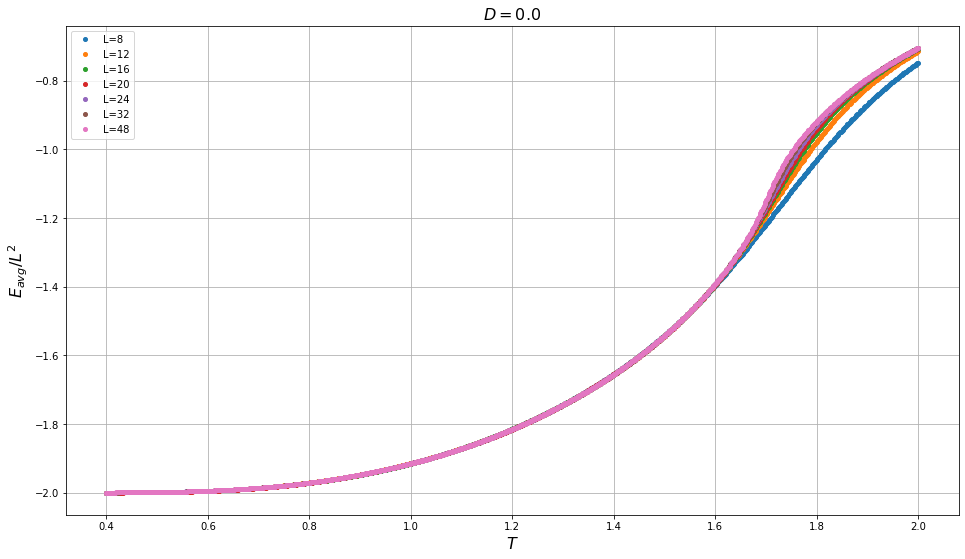

In [44]:
#plot co-plots for heat capacity, E_avg and Binder Cummulant
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters, desc='over parameters')):
    st = parameters[i]["stitched"]
    L = st['L']
    plt.plot([float(T) for T in E[L]], [float(E) / (L * L) for T, E in E[L].items()], 'o', markerSize = 4,
             label='L={}'.format(st["L"]))

plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$E_{avg} / L^2$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
plt.savefig("./images/E_avg(T)_D{}.png".format(st["D"]))


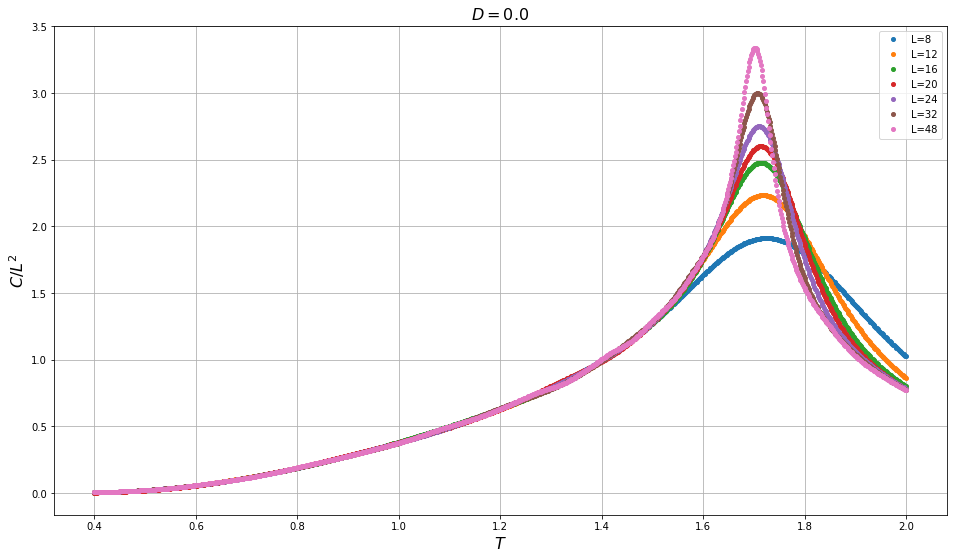

In [47]:
#plot co-plots for heat capacity, E_avg and Binder Cummulant
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters, desc='over parameters')):
    st = parameters[i]["stitched"]
    L = st['L']
    plt.plot([float(T) for T in hc[L]], [float(C) / (L * L) for T, C in hc[L].items()], 'o', markerSize = 4,
             label='L={}'.format(L))
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$C / L^2$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
plt.savefig("./images/C(T)_D{}.png".format(st["D"]))


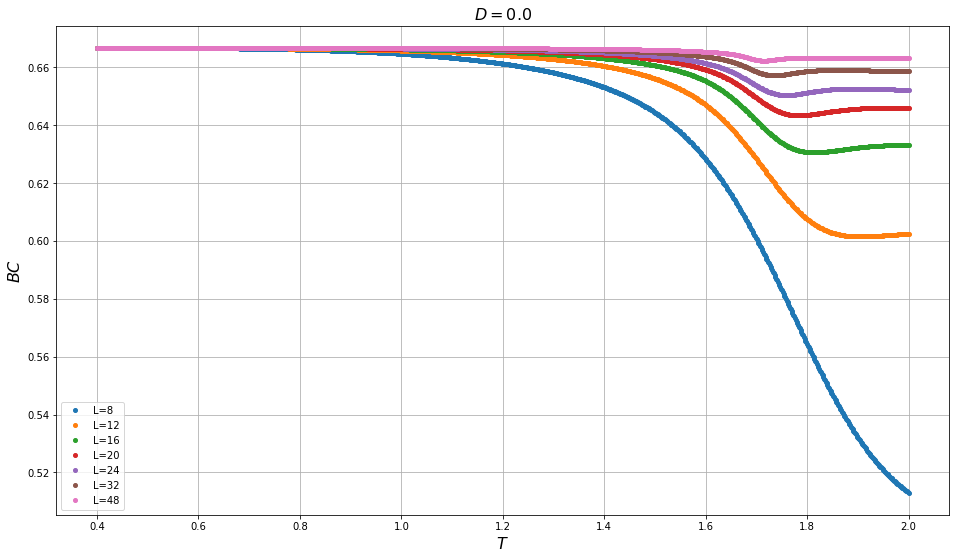

In [48]:
#plot co-plots for heat capacity, E_avg and Binder Cummulant
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters, desc='over parameters')):
    st = parameters[i]["stitched"]
    L = st['L']
    plt.plot([float(T) for T in BC[L]], [bc for T, bc in BC[L].items()], 'o', markerSize = 4,
             label='L={}'.format(st["L"]))

plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$BC$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


In [53]:
def keywithmaxval(d):
     """ a) create a list of the dict's keys and values; 
         b) return the key with the max value"""  
     v = list(d.values())
     k = list(d.keys())
     return k[v.index(max(v))]

In [56]:
T_crit = {}

In [62]:
#calc T_crit and C_crit



for i, x in enumerate(tqdm(parameters, desc='over parameters')):
    st = x["stitched"]
    L = st["L"]
    a, b = keywithmaxval(hc[L]) - 0.1, keywithmaxval(hc[L]) + 0.1
    t, c, _, _ = fminbound(lambda T: -calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }
with open("./tmp/T_crit_D{}.txt".format(D), 'w') as fp:
    json.dump(T_crit, fp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


KeyboardInterrupt: 

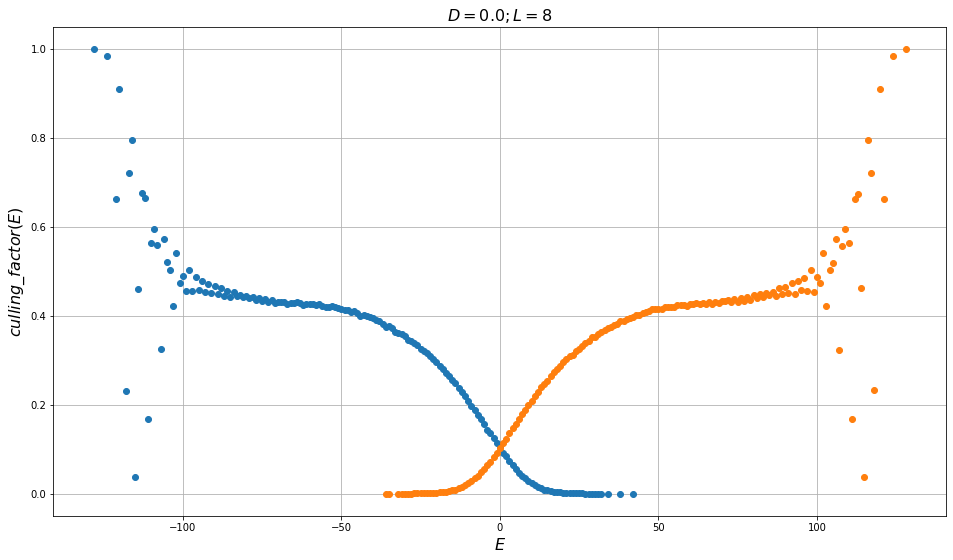

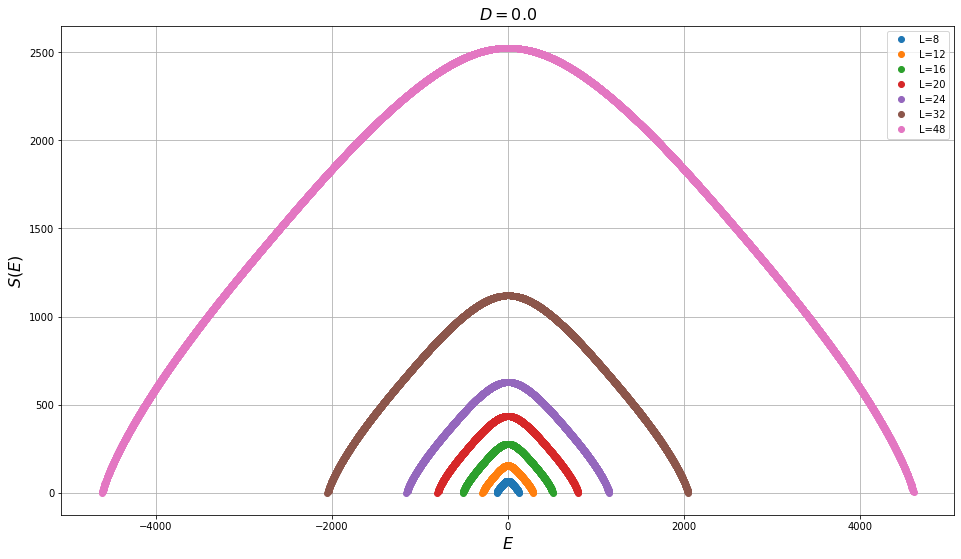

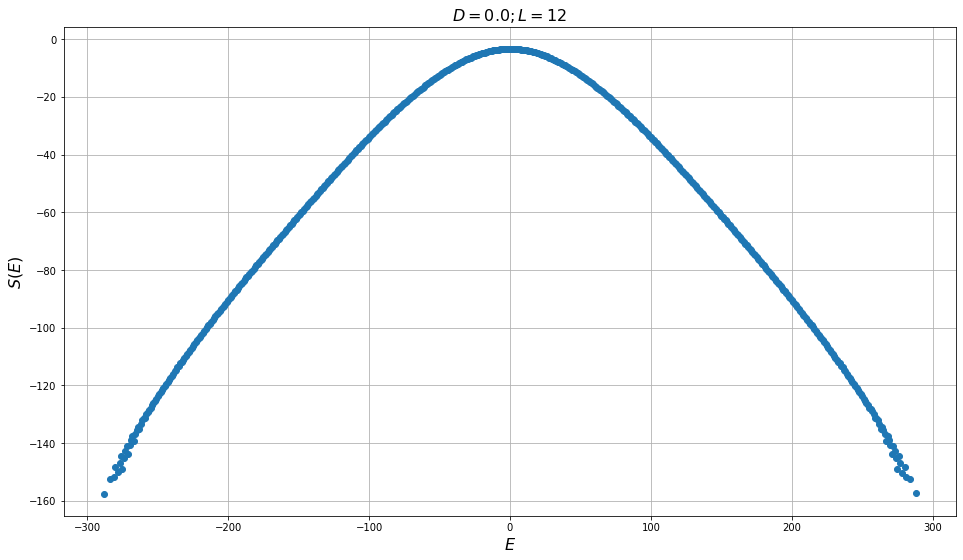

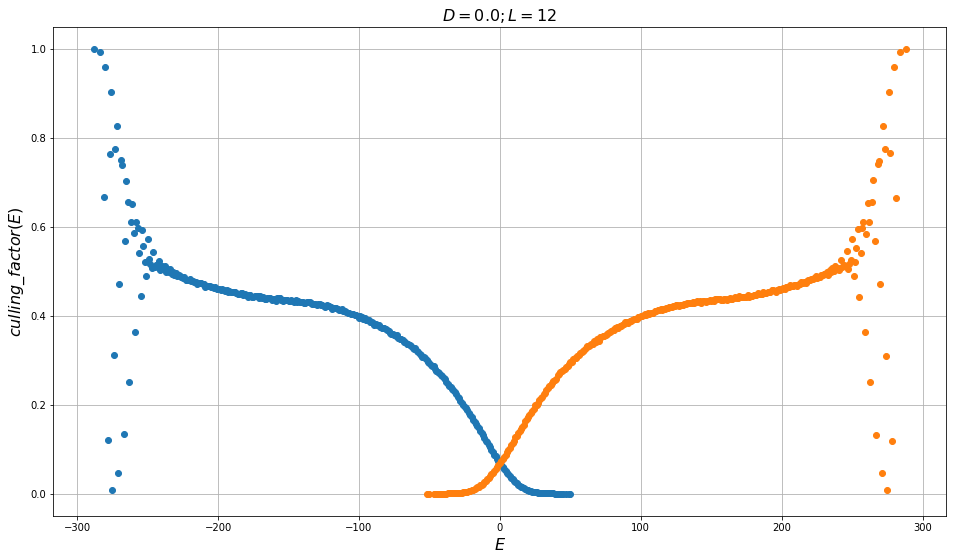

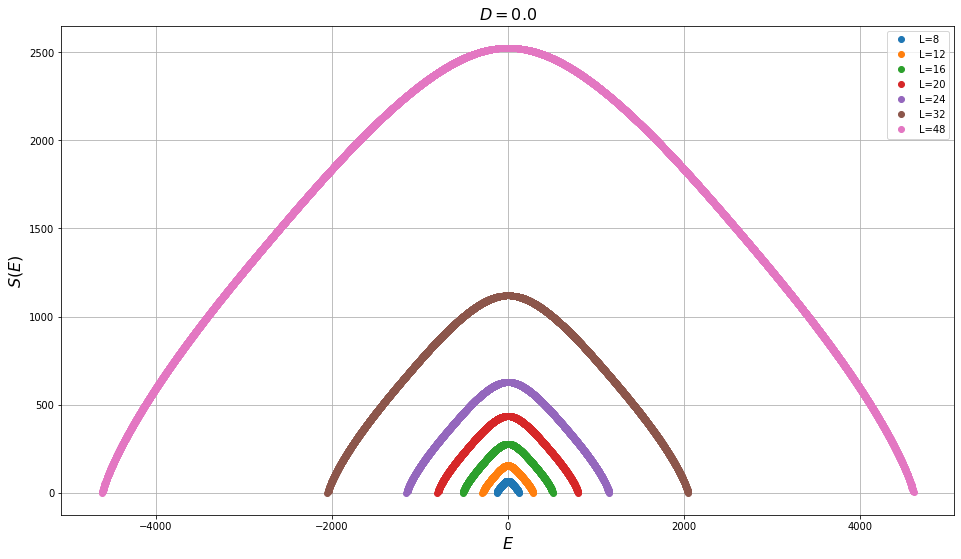

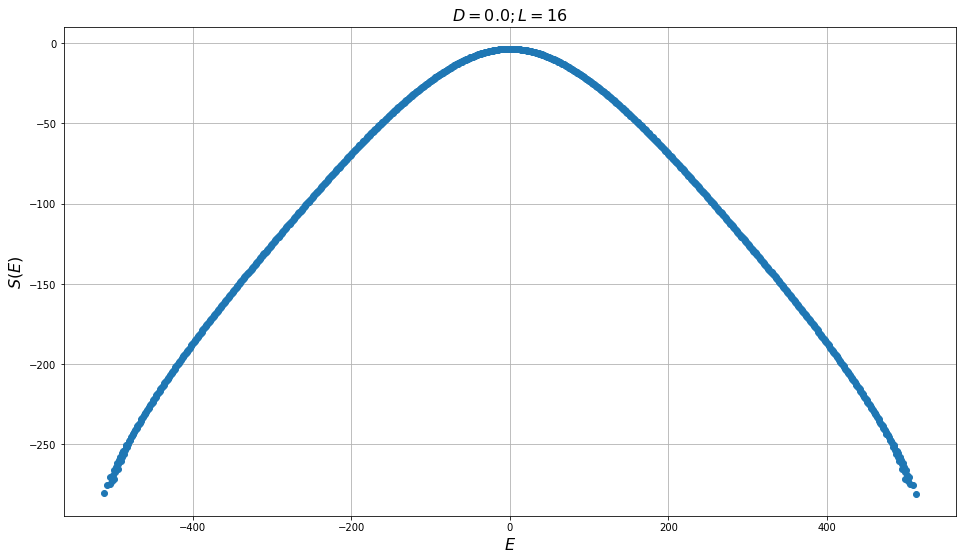

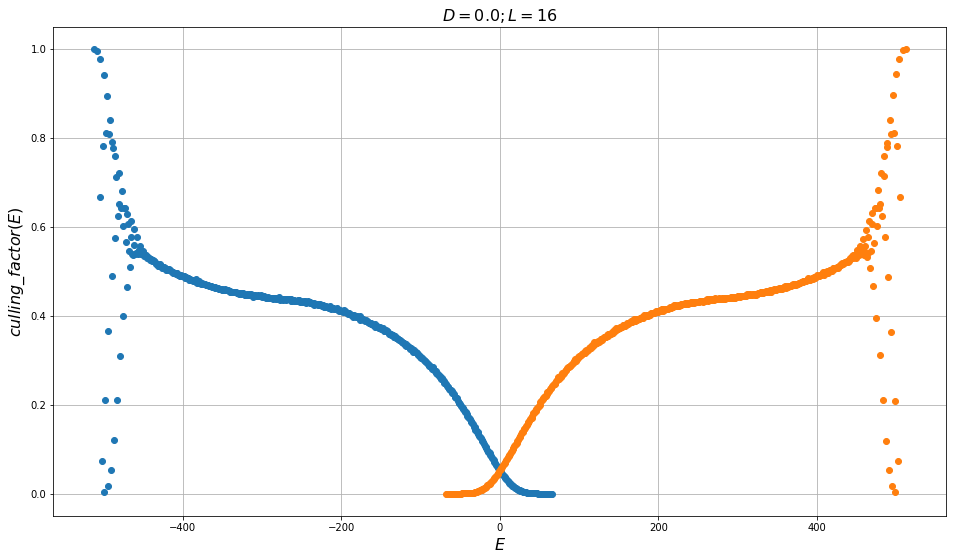

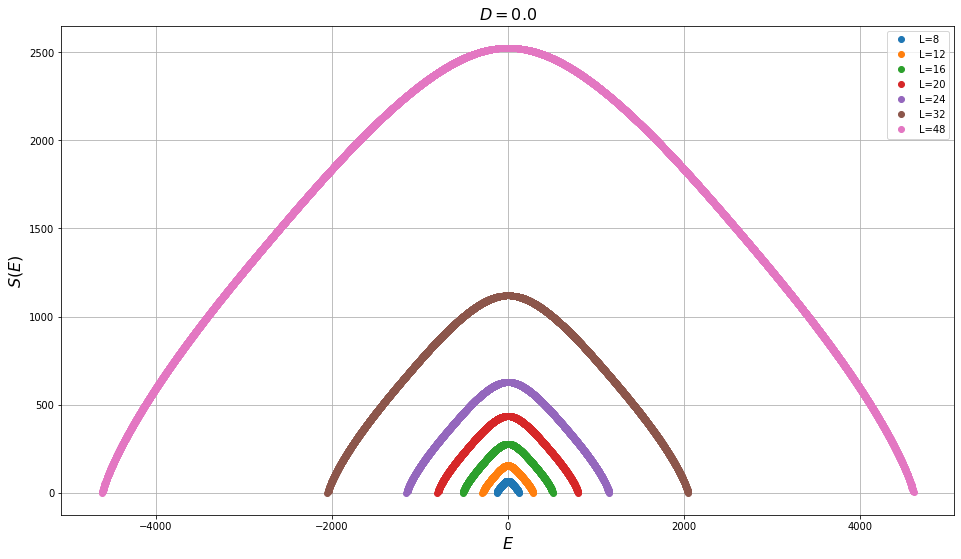

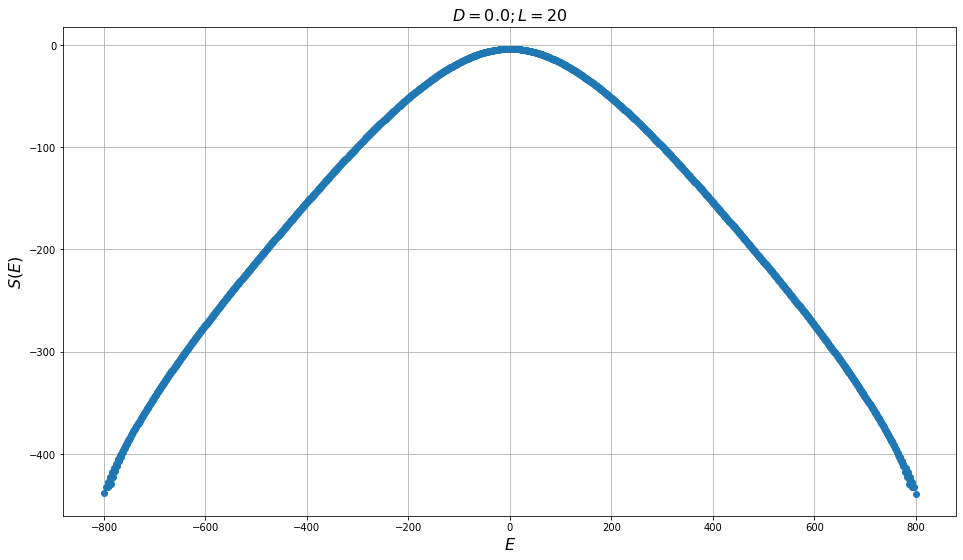

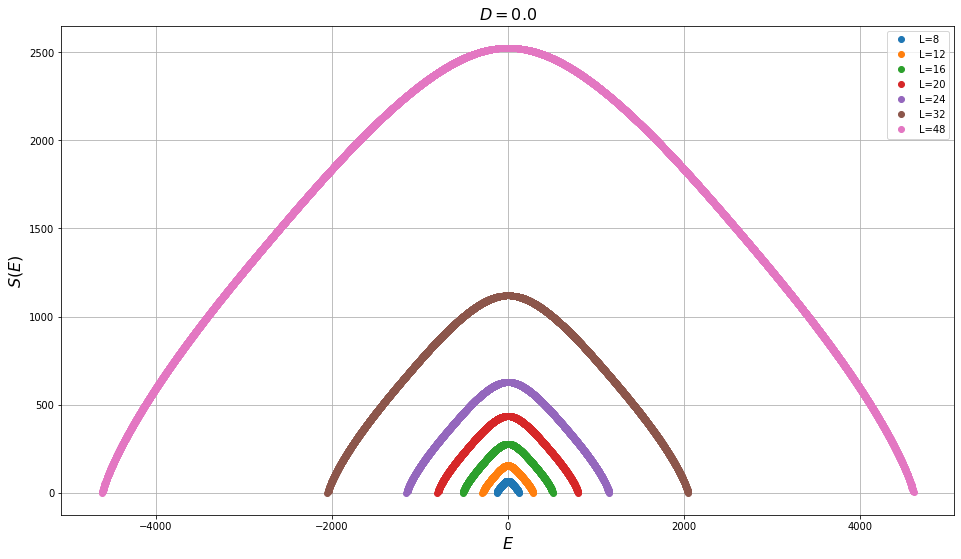

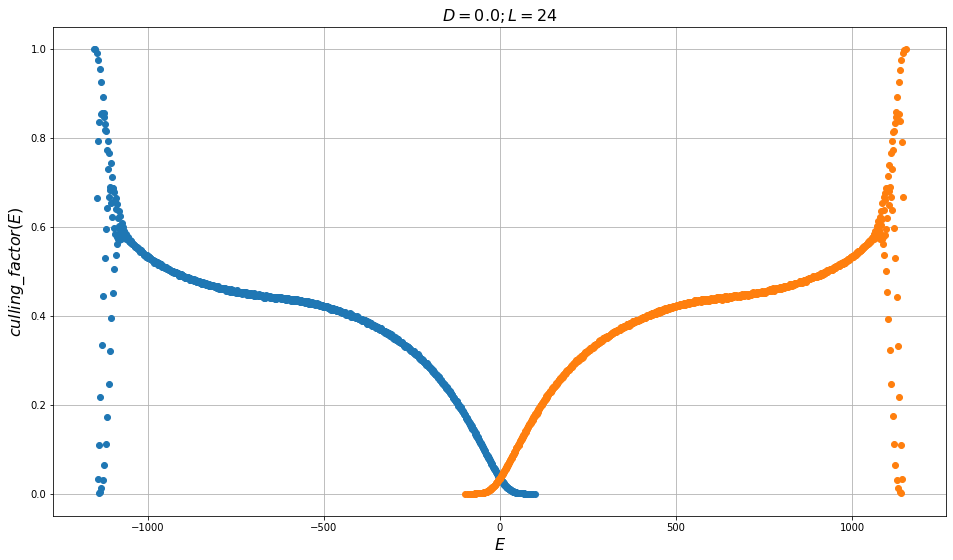

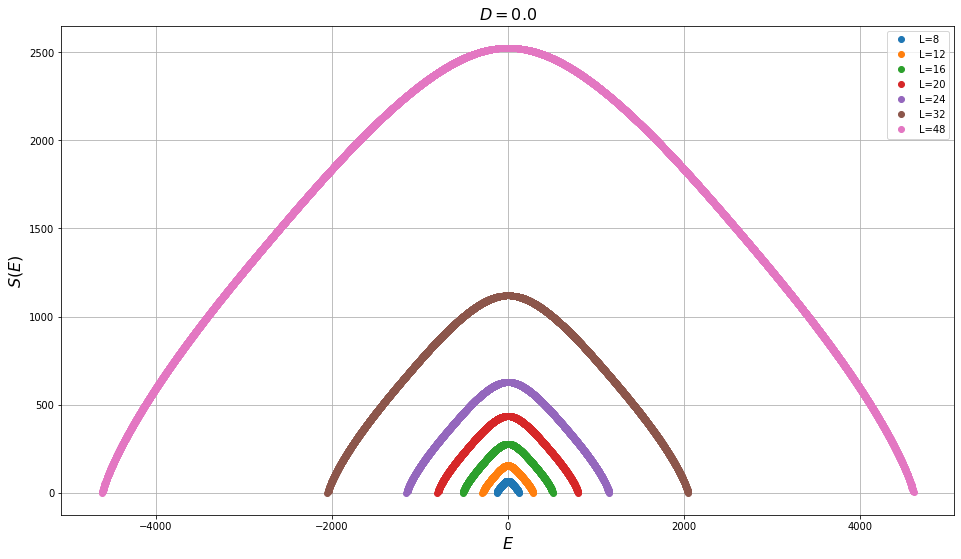

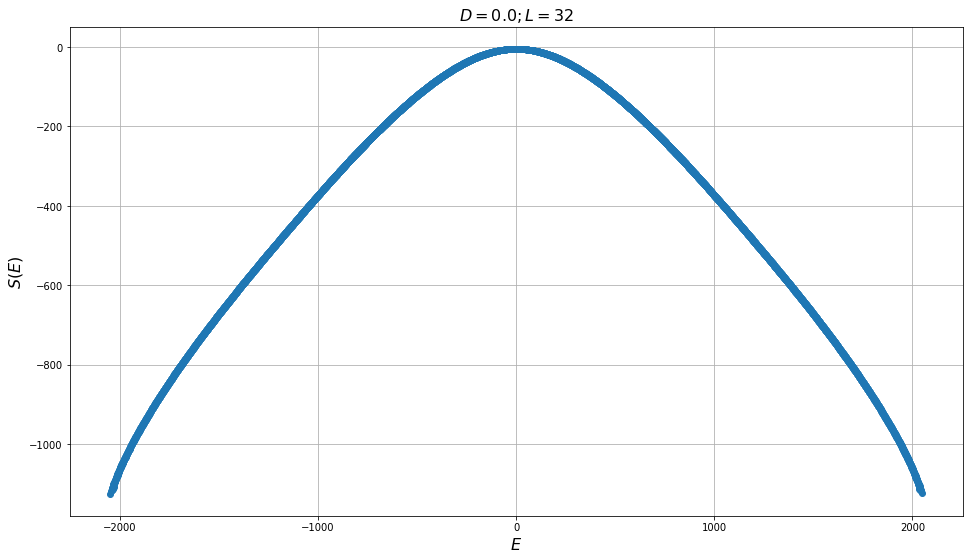

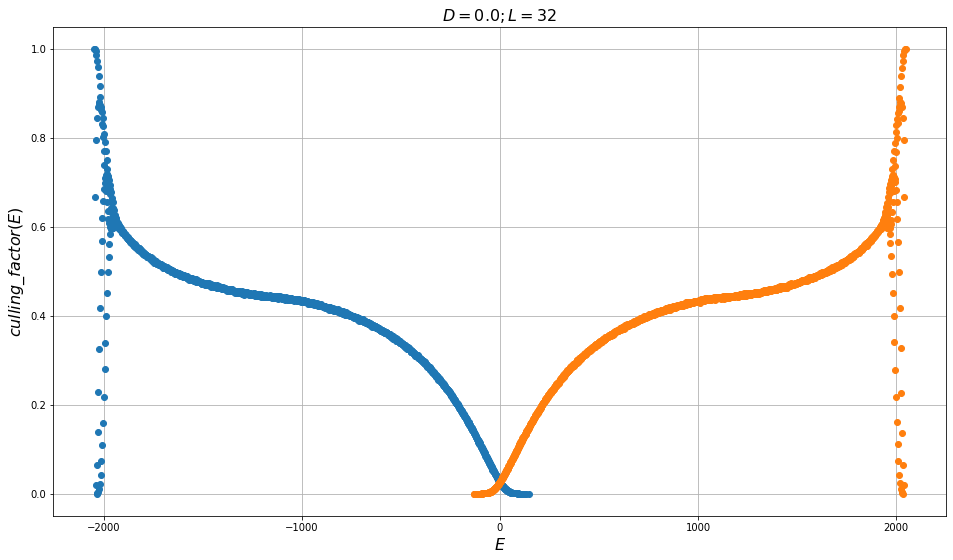

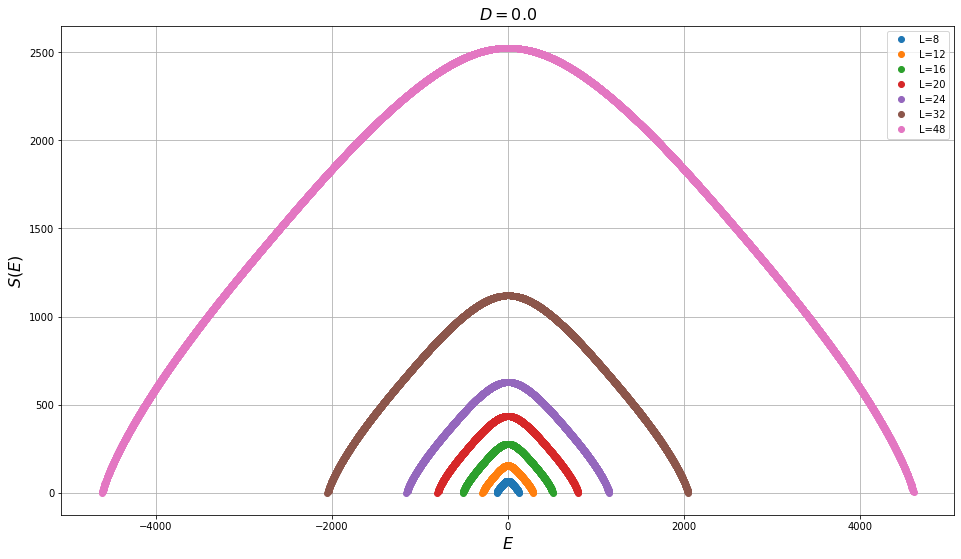

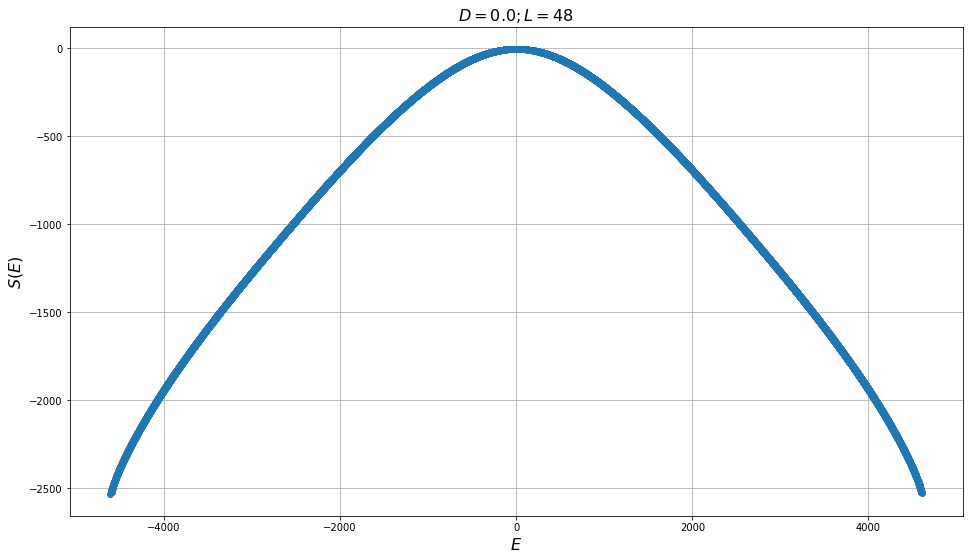

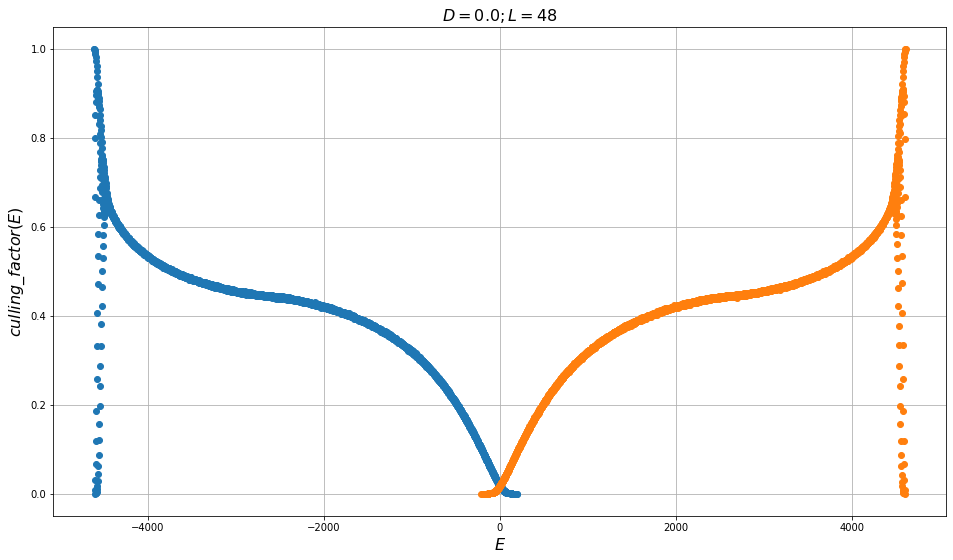

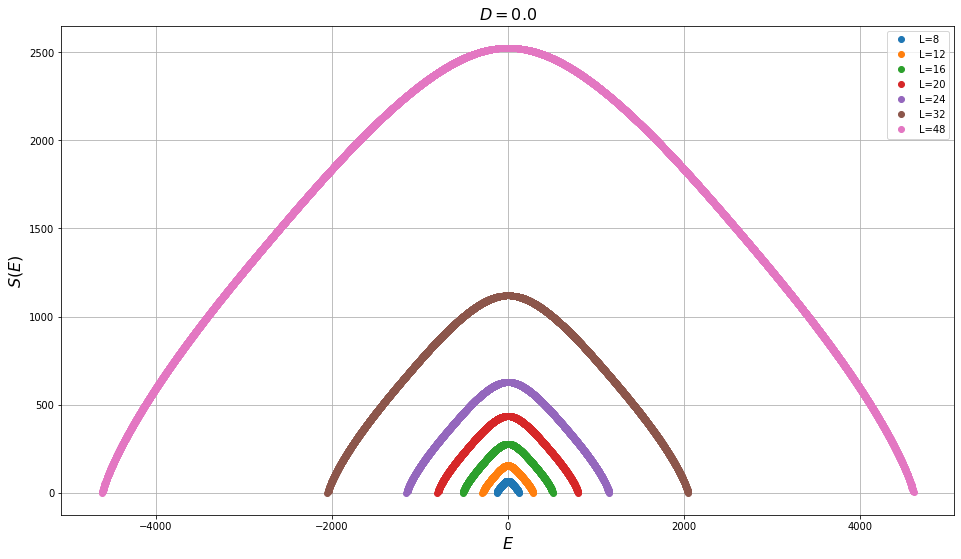

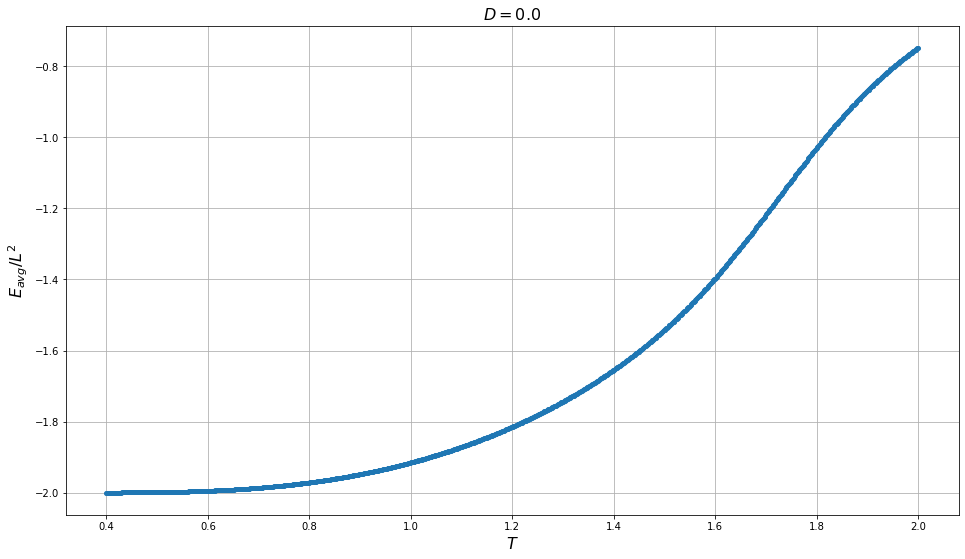

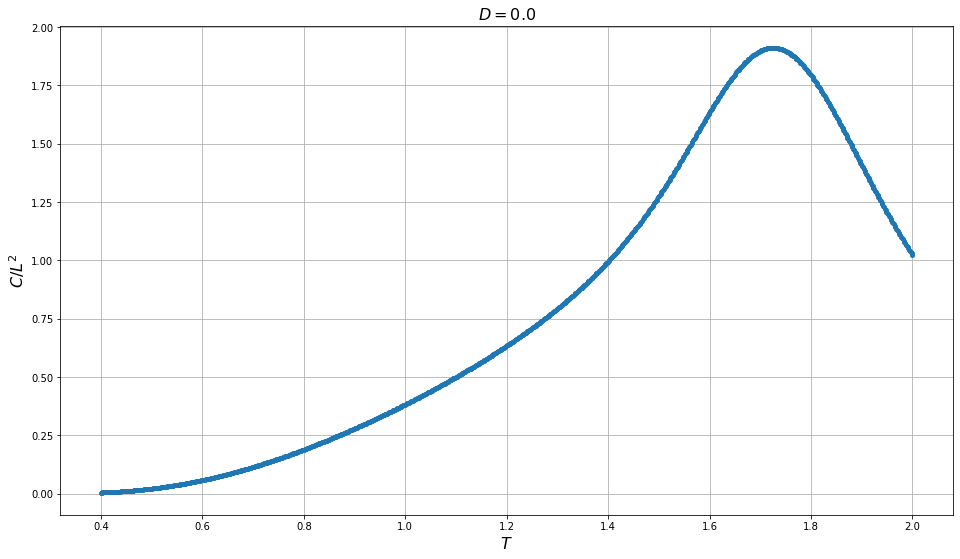

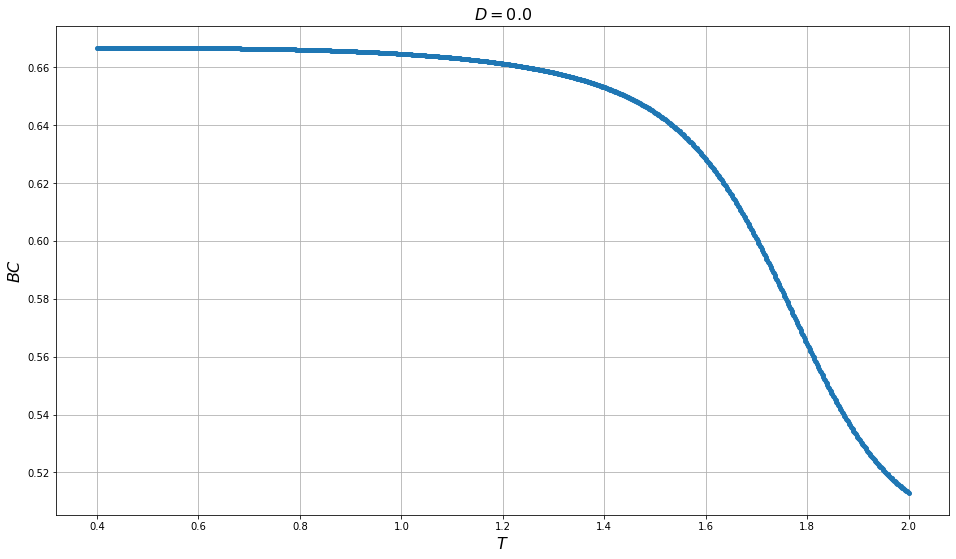

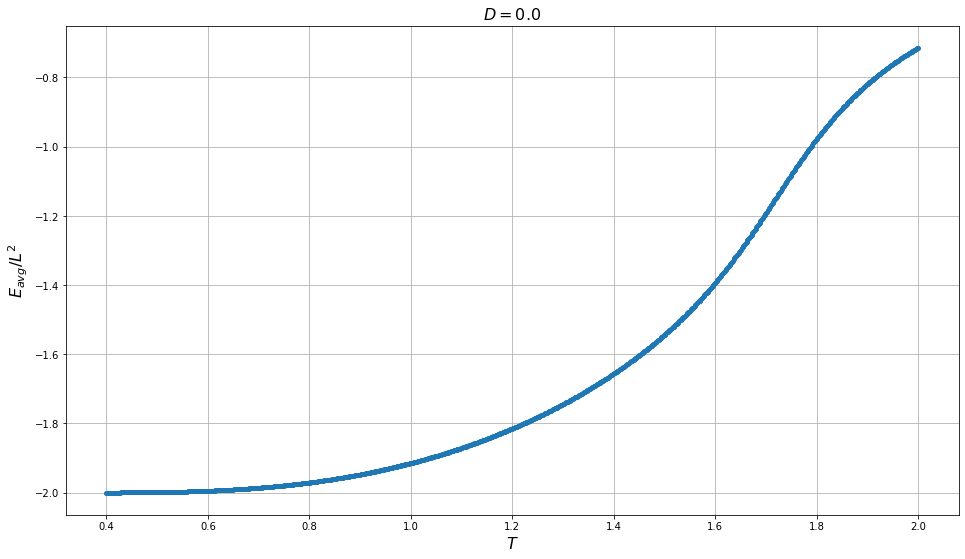

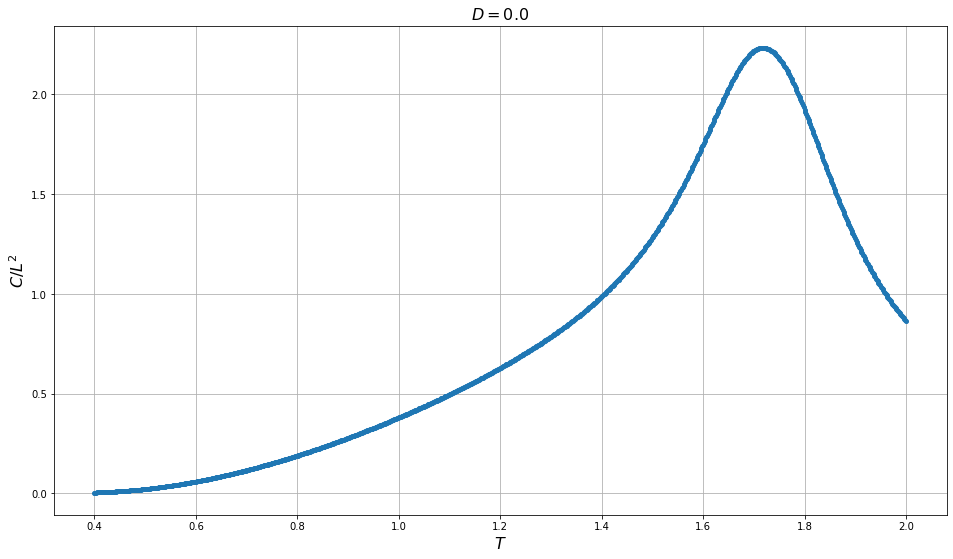

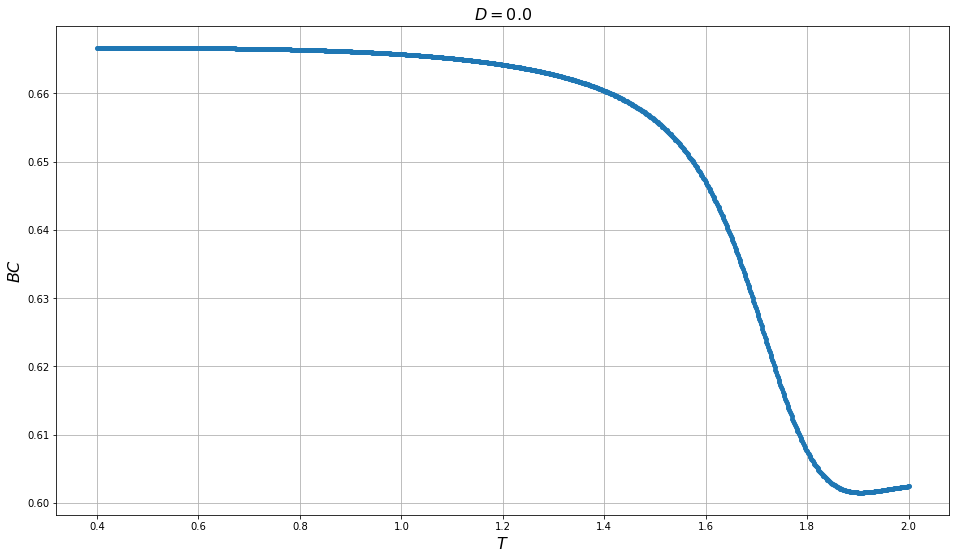

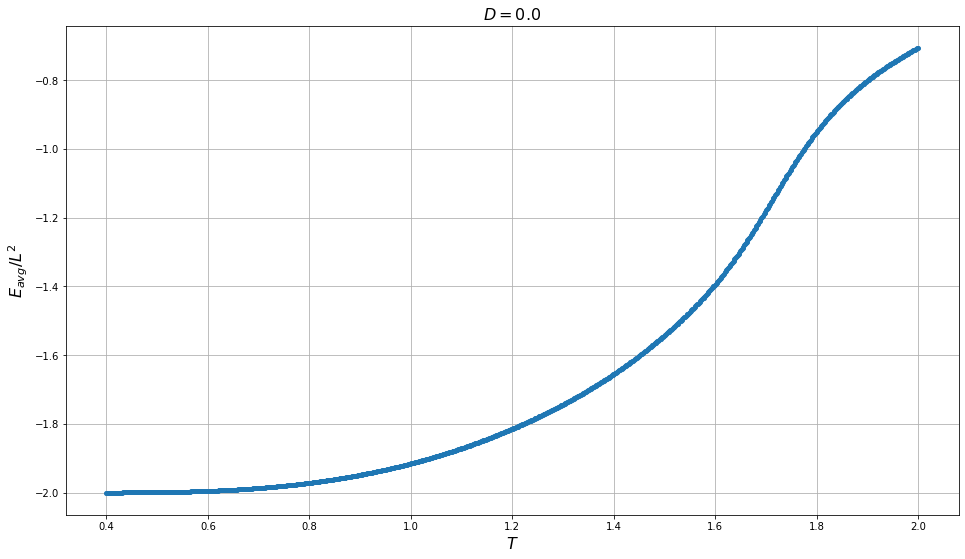

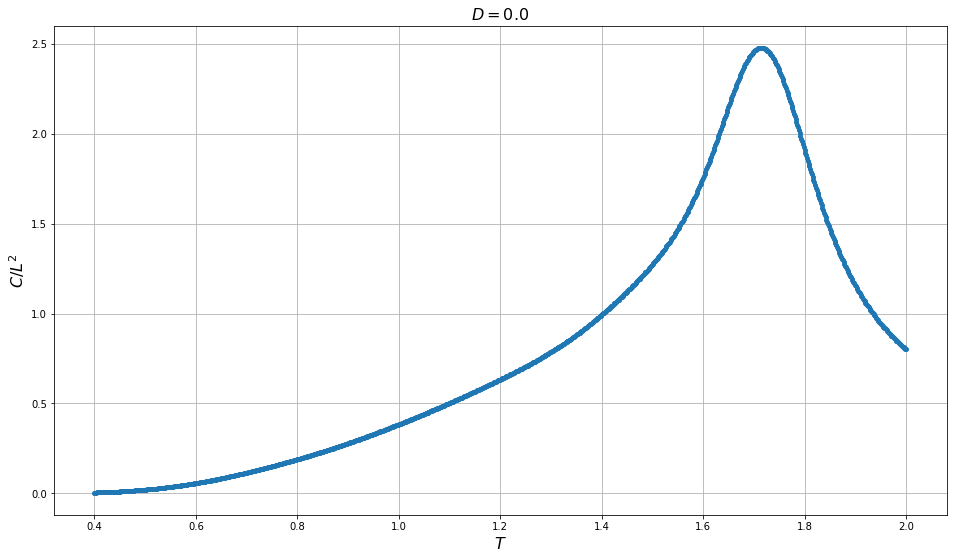

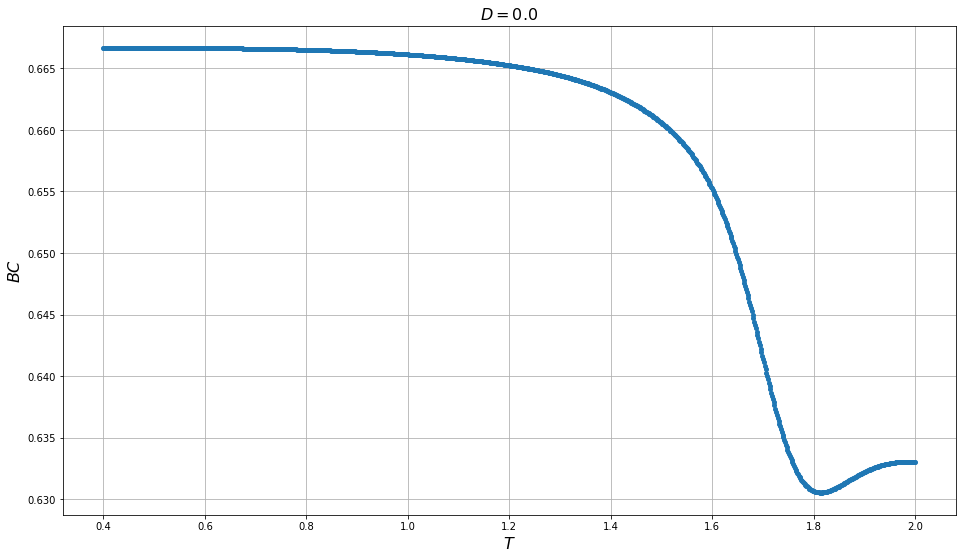

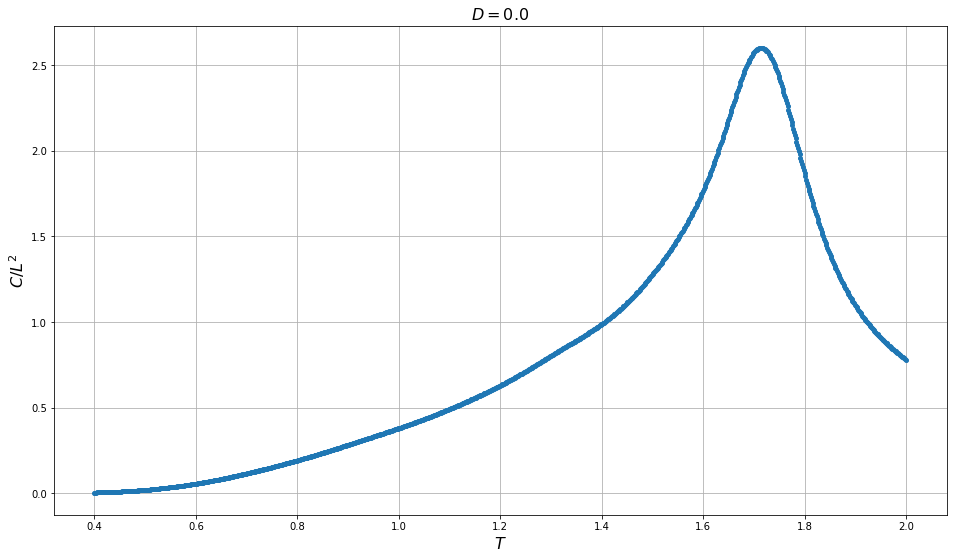

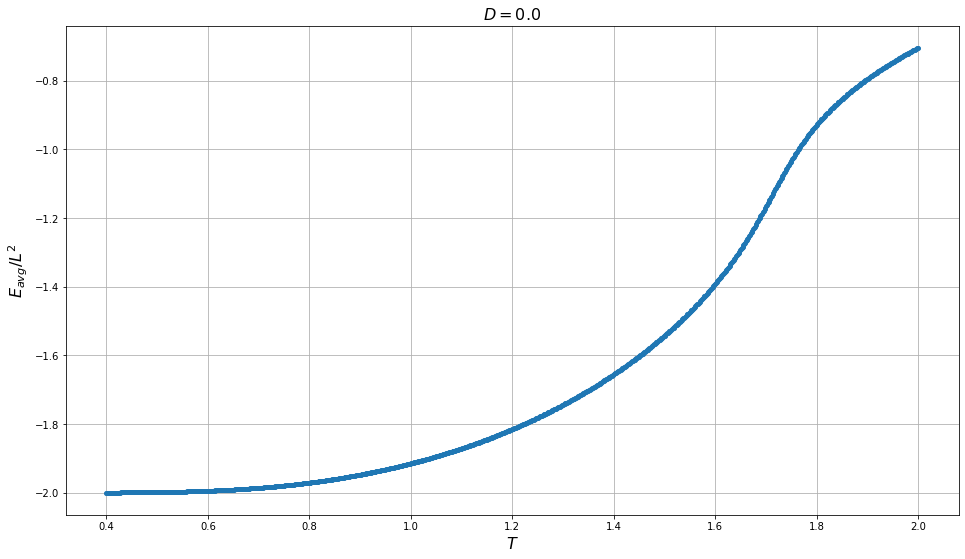

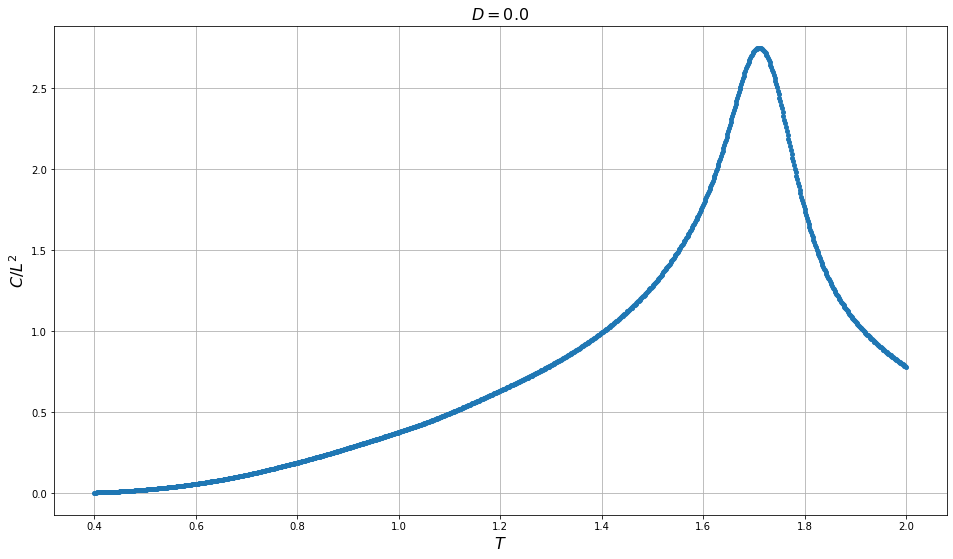

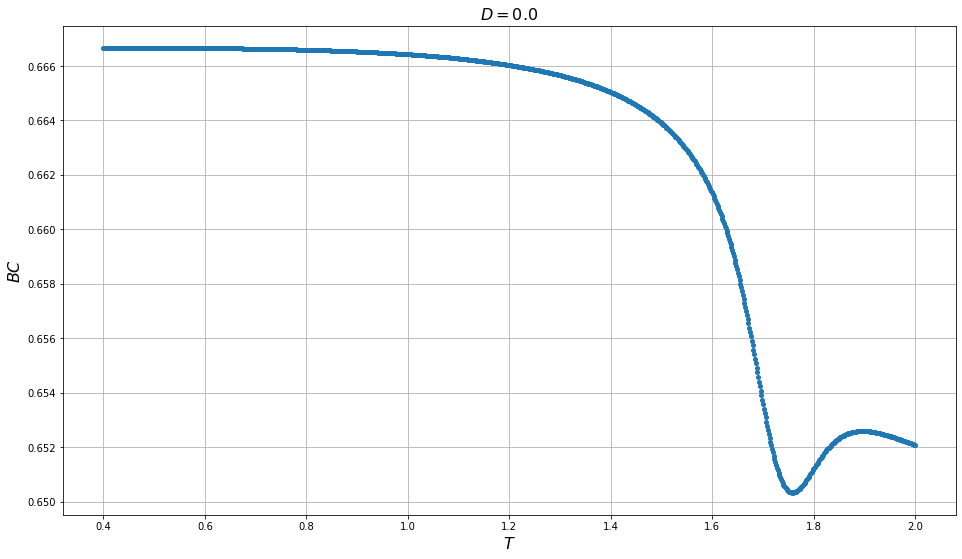

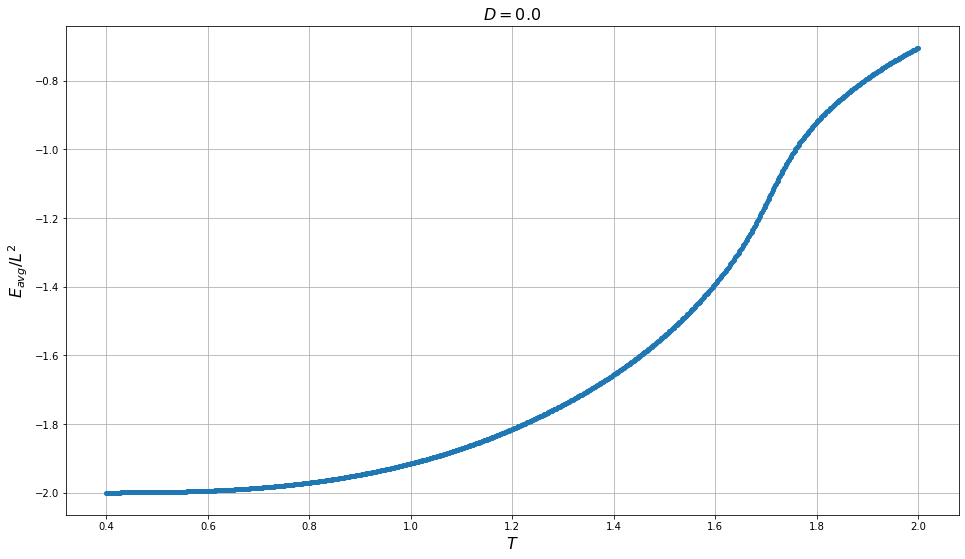

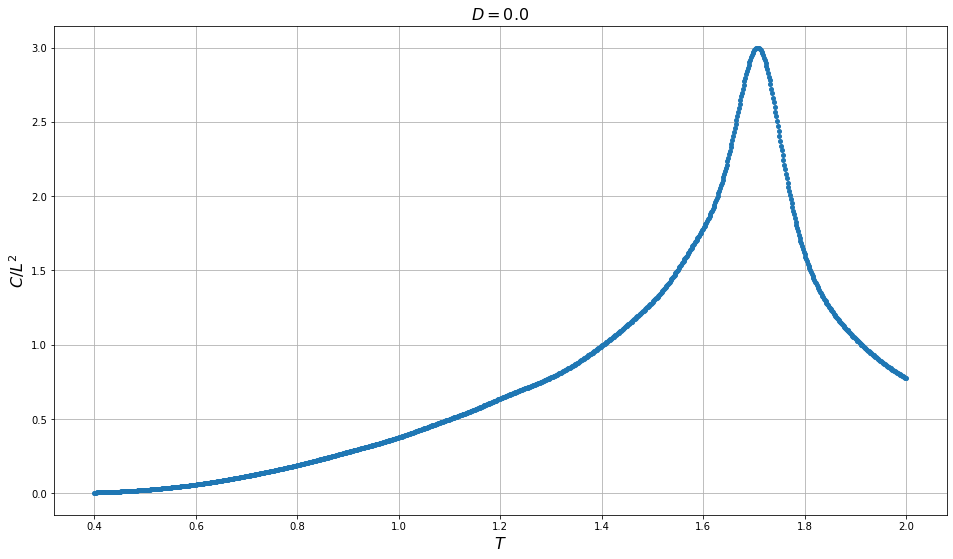

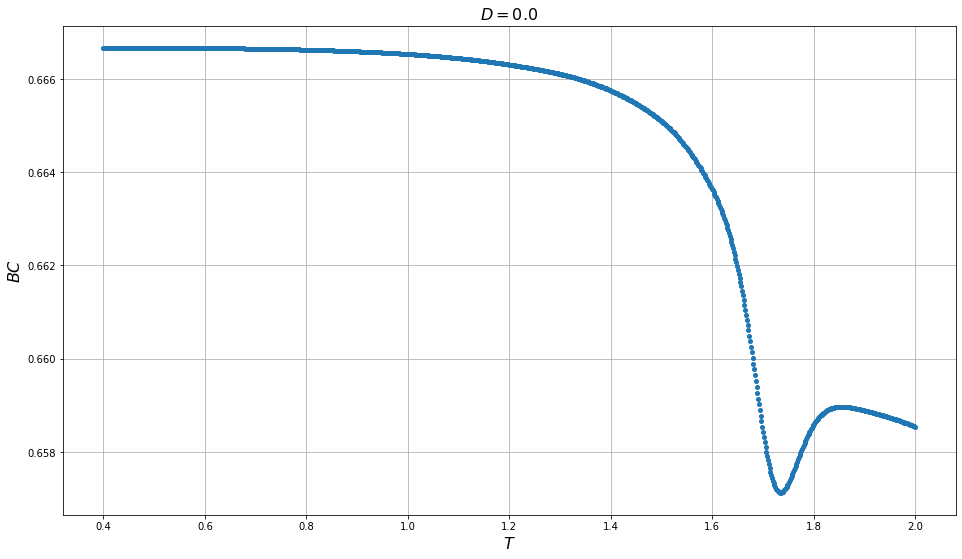

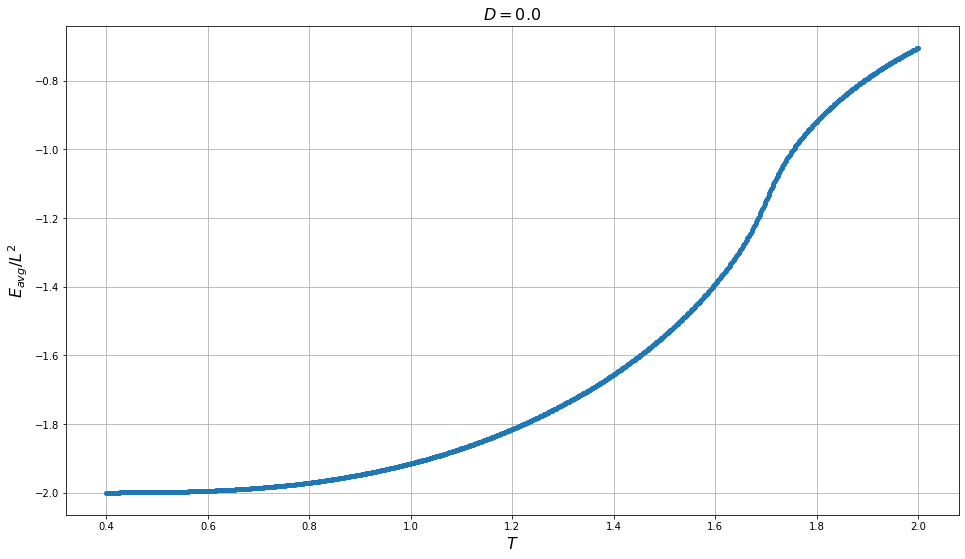

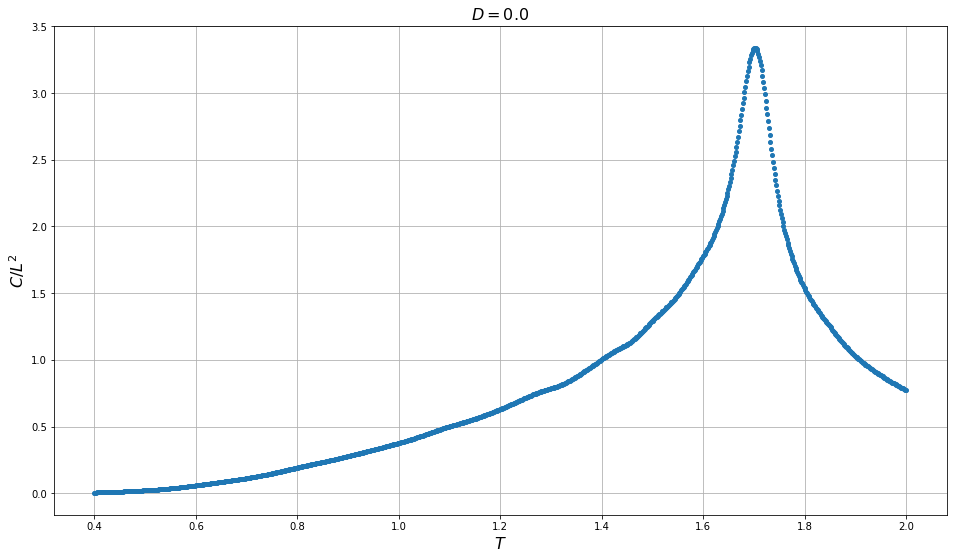

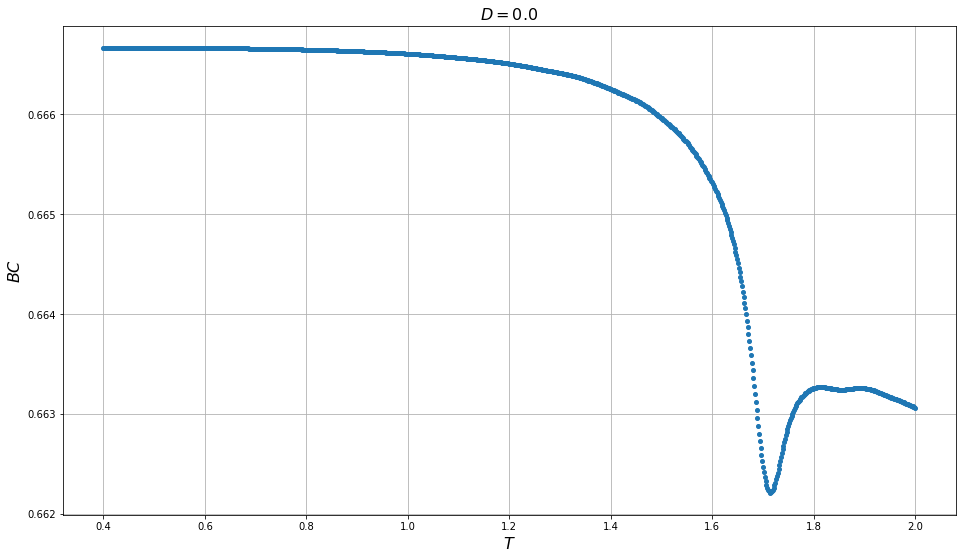

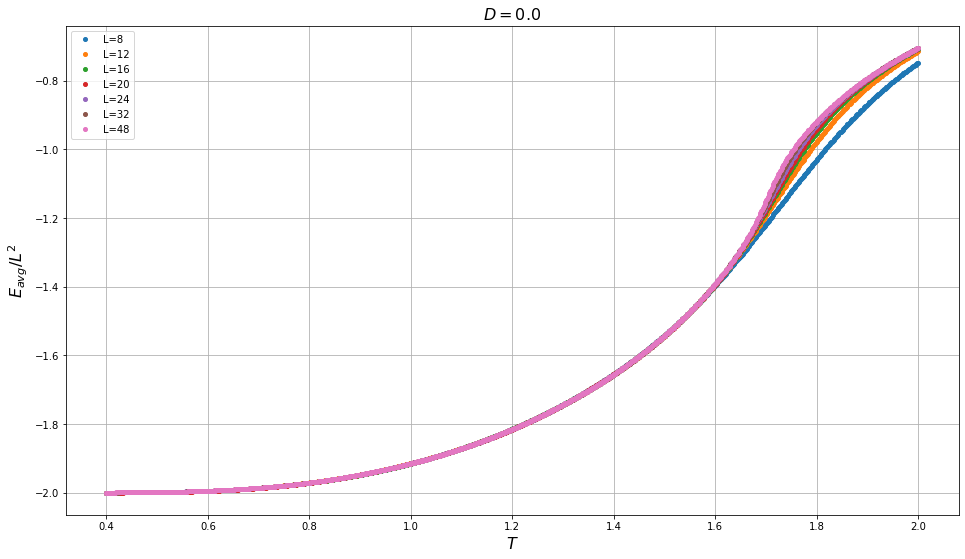

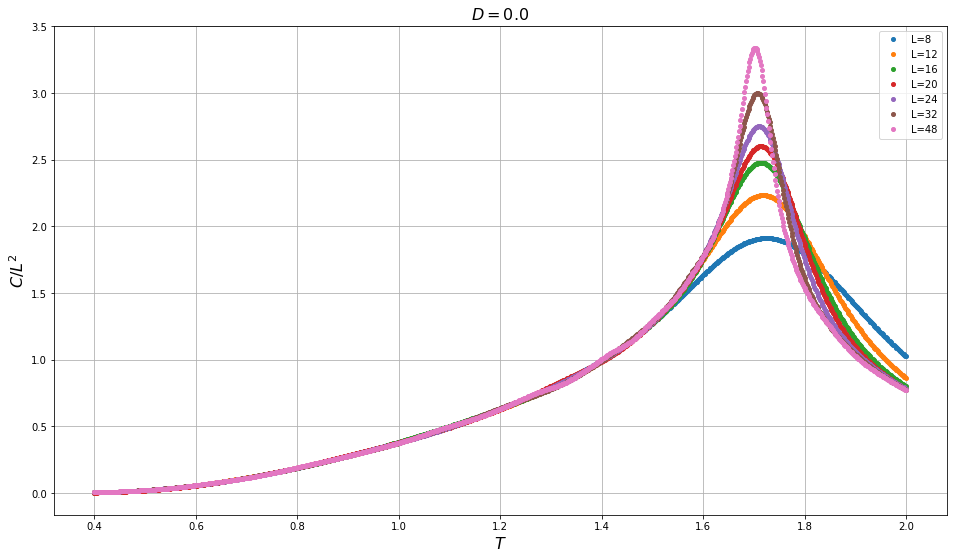

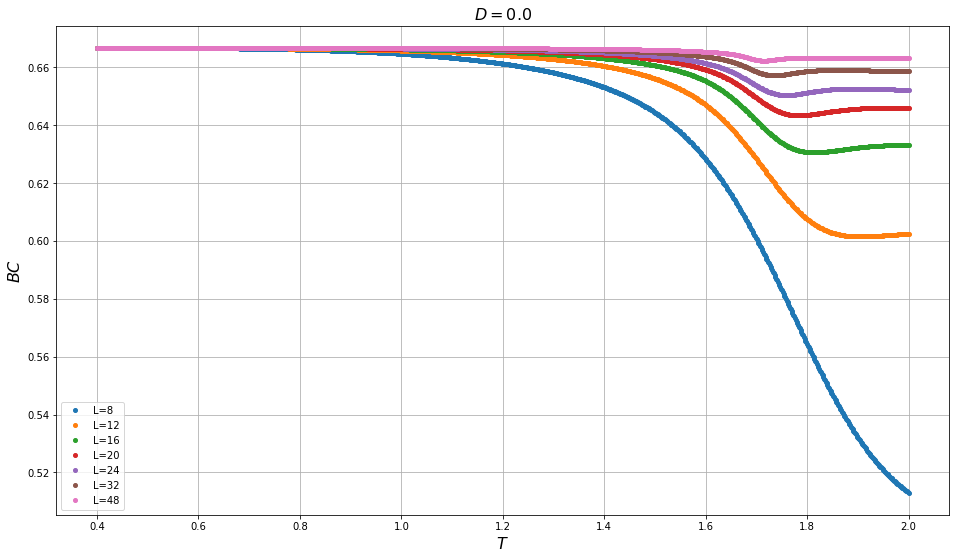

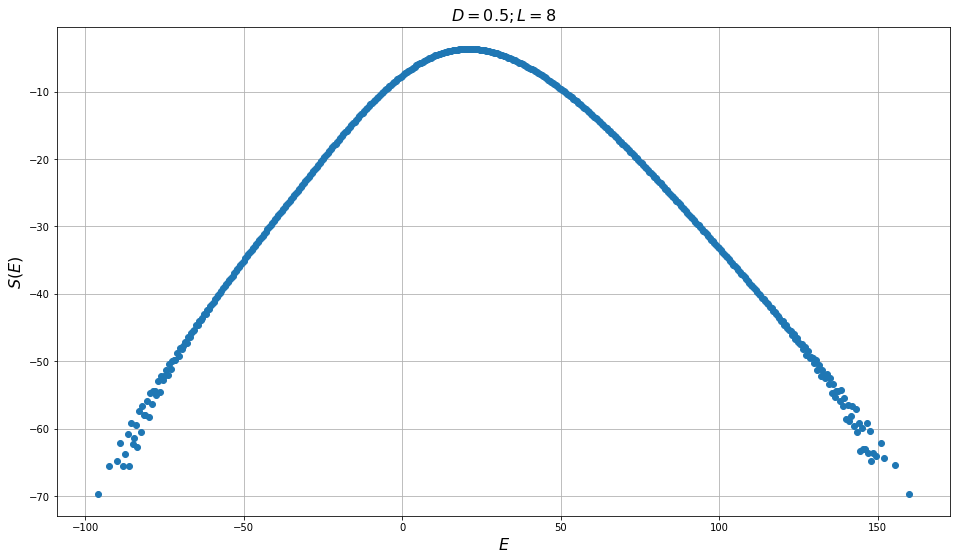

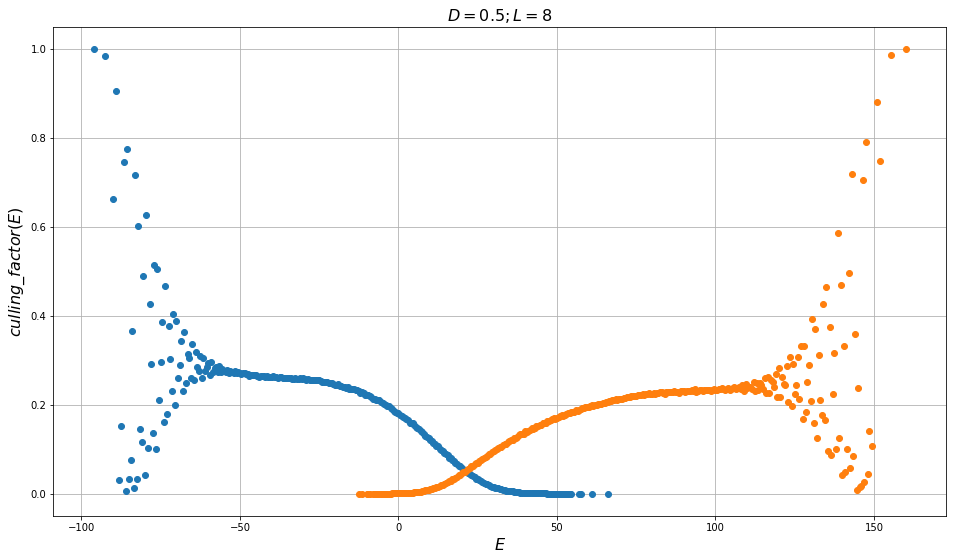

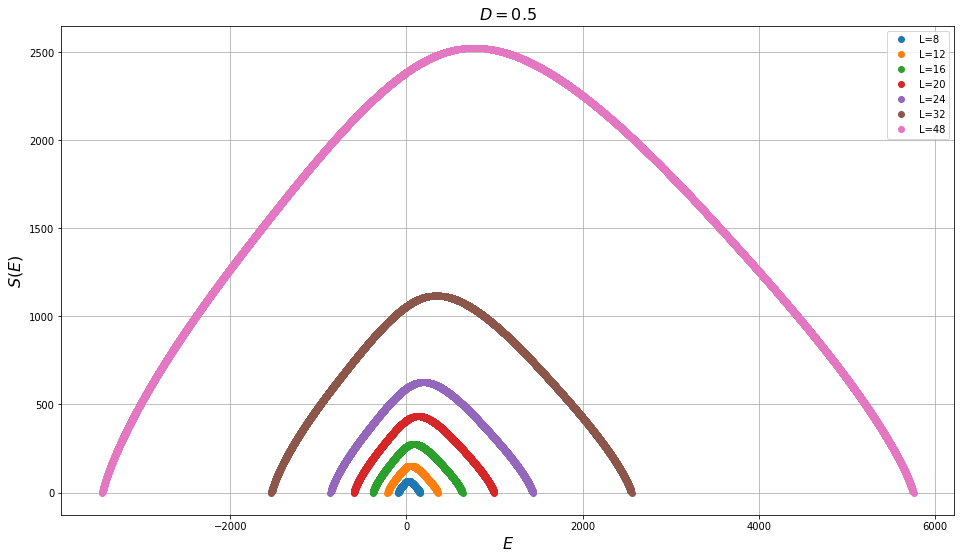

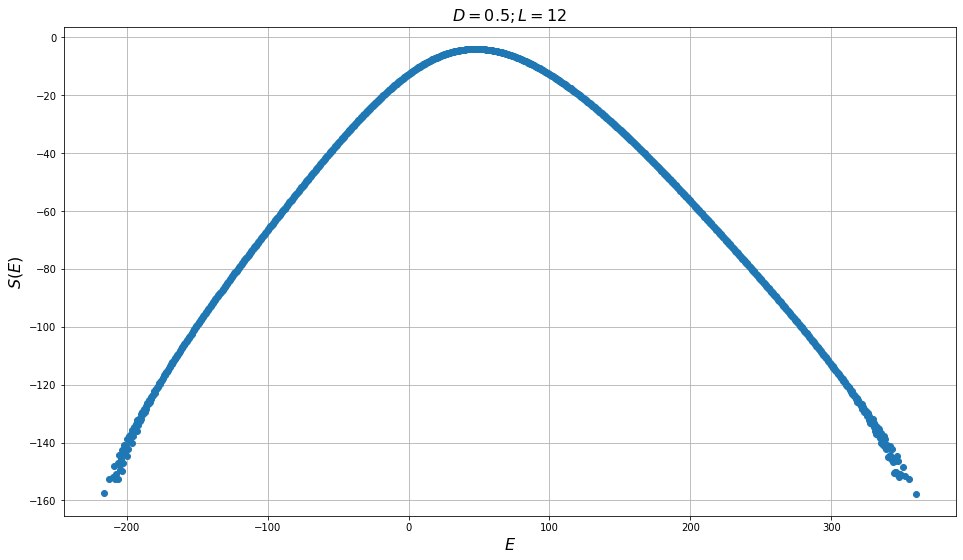

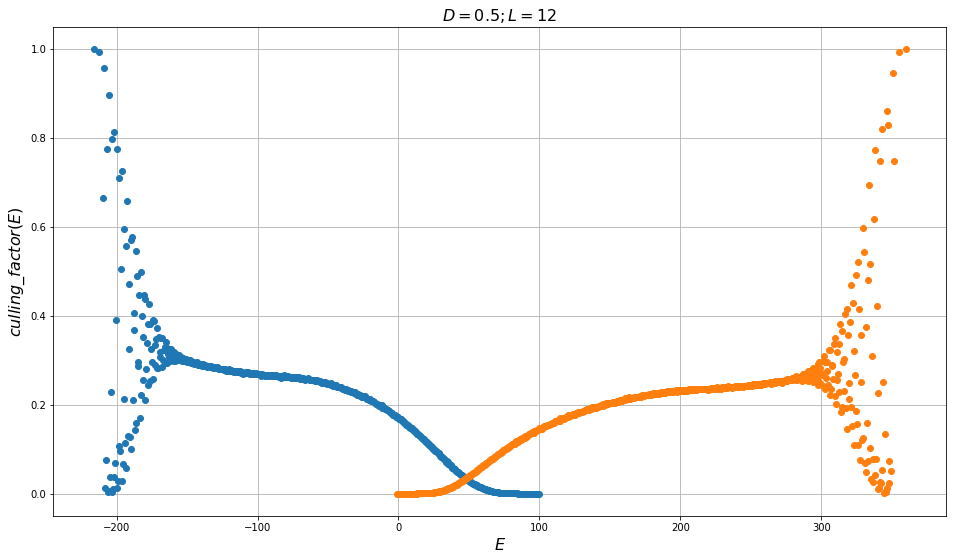

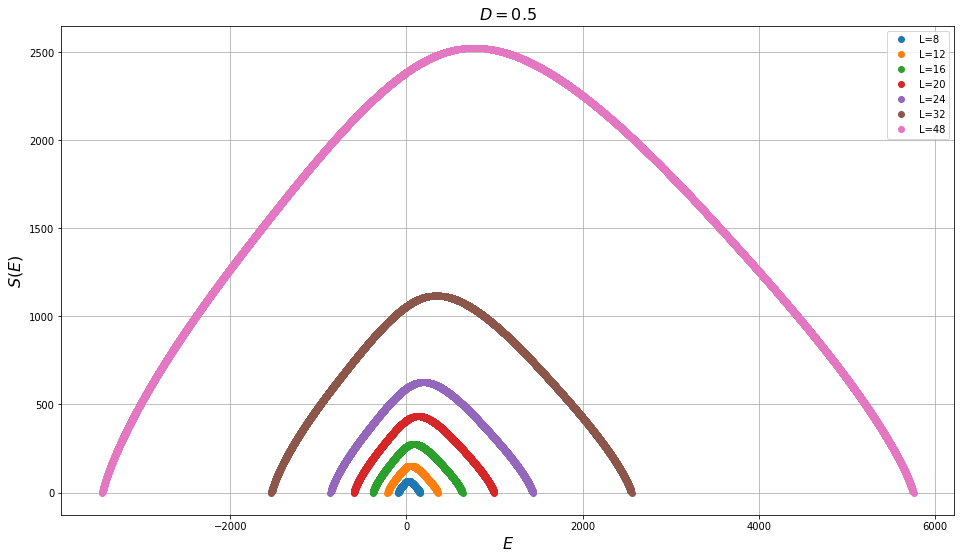

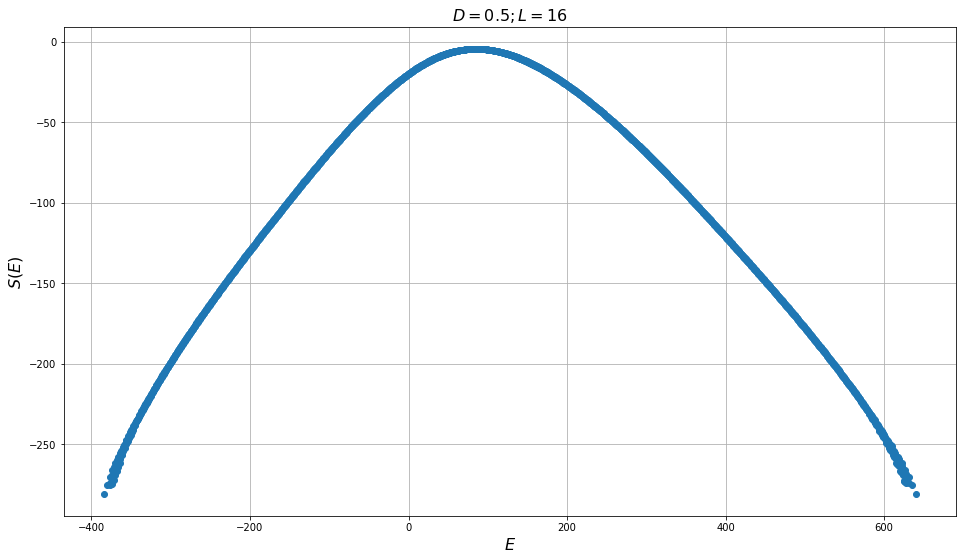

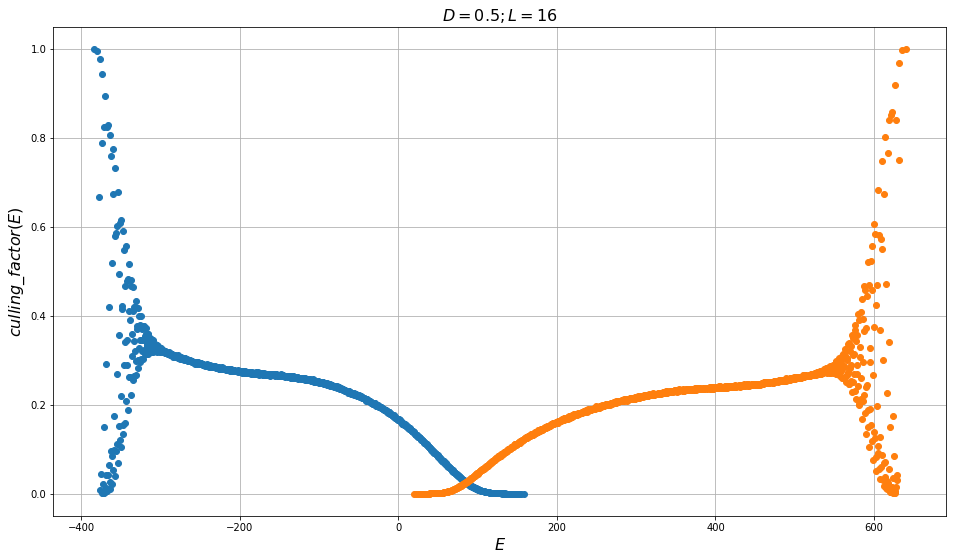

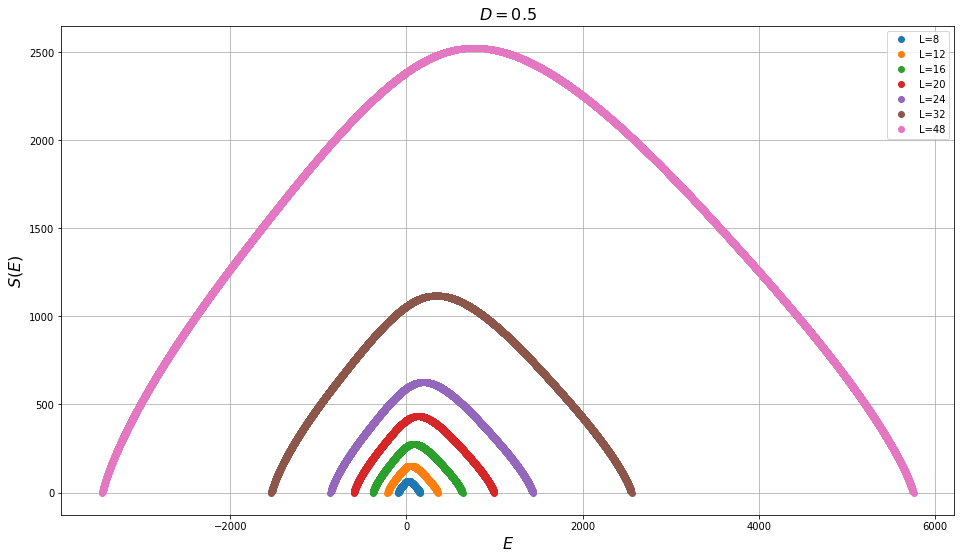

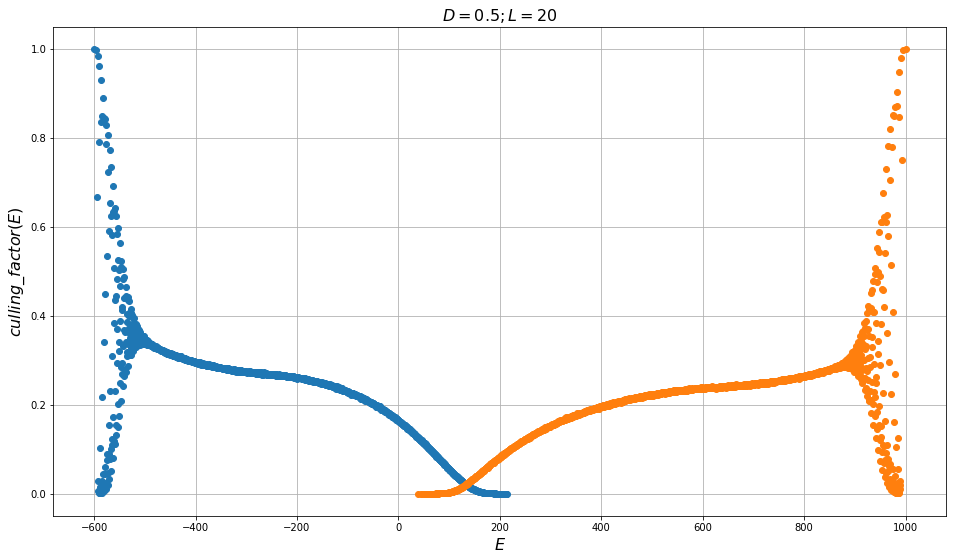

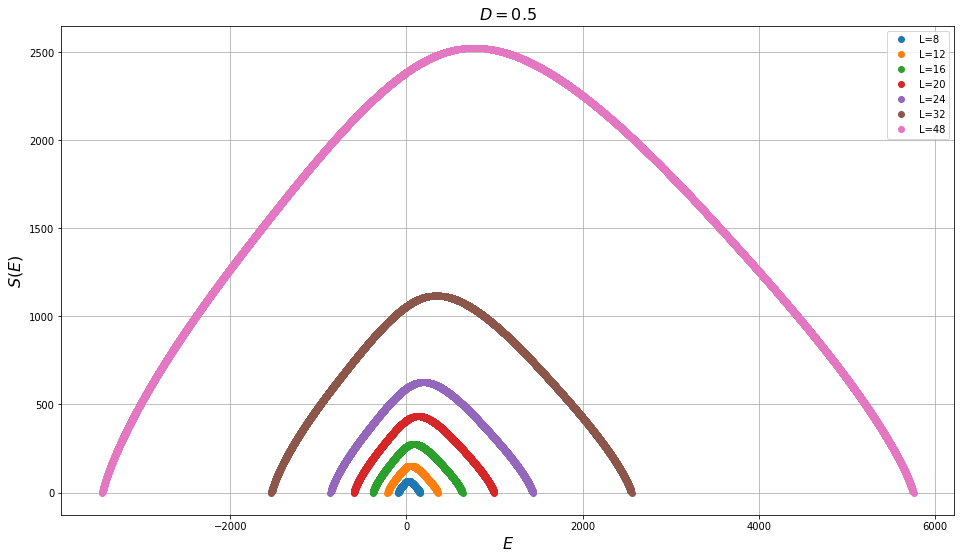

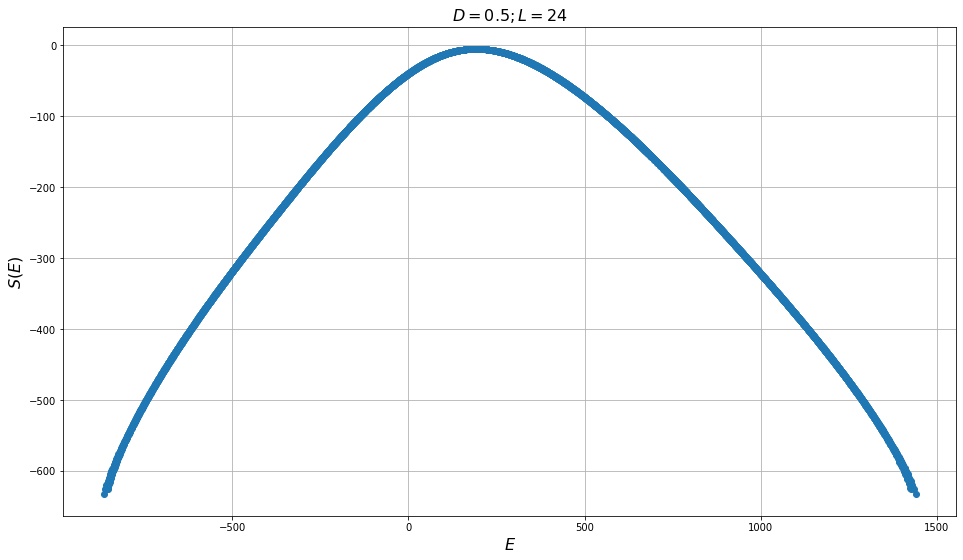

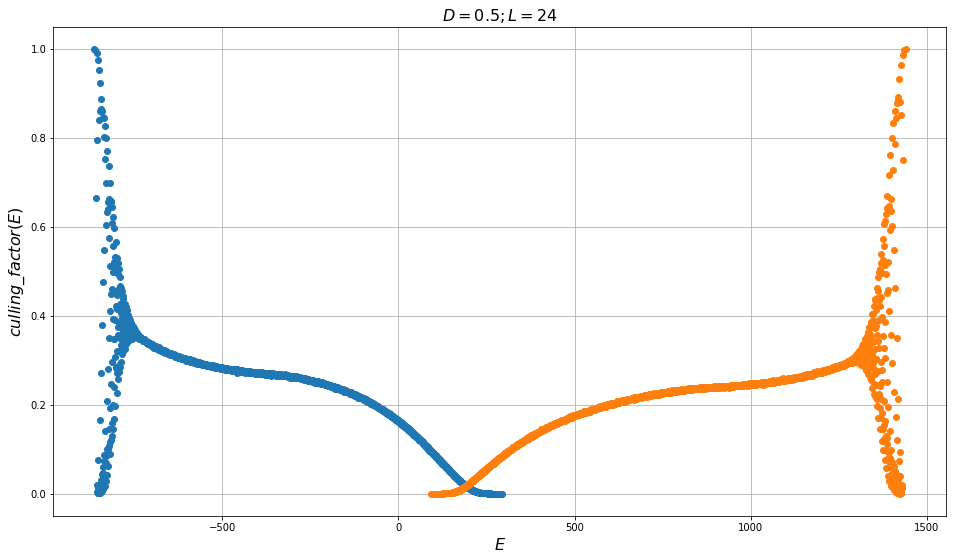

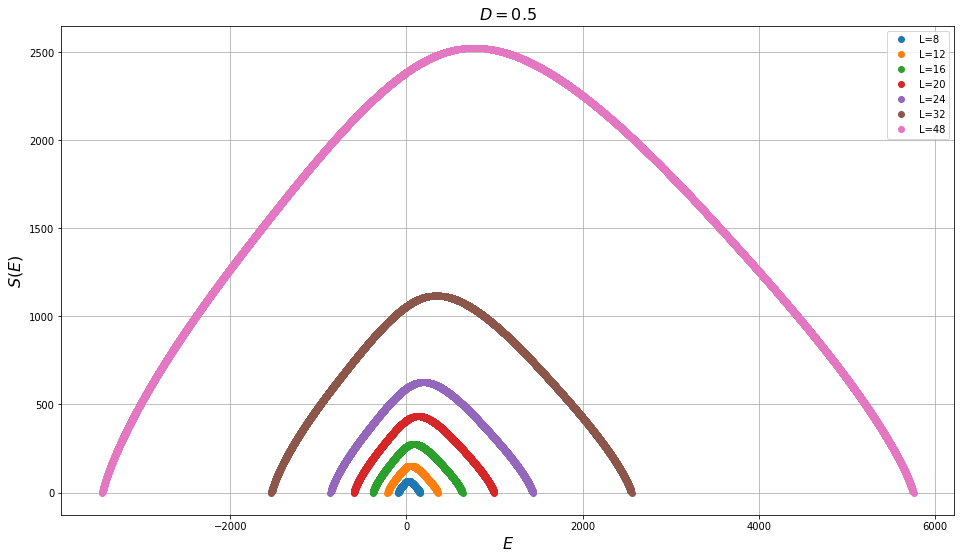

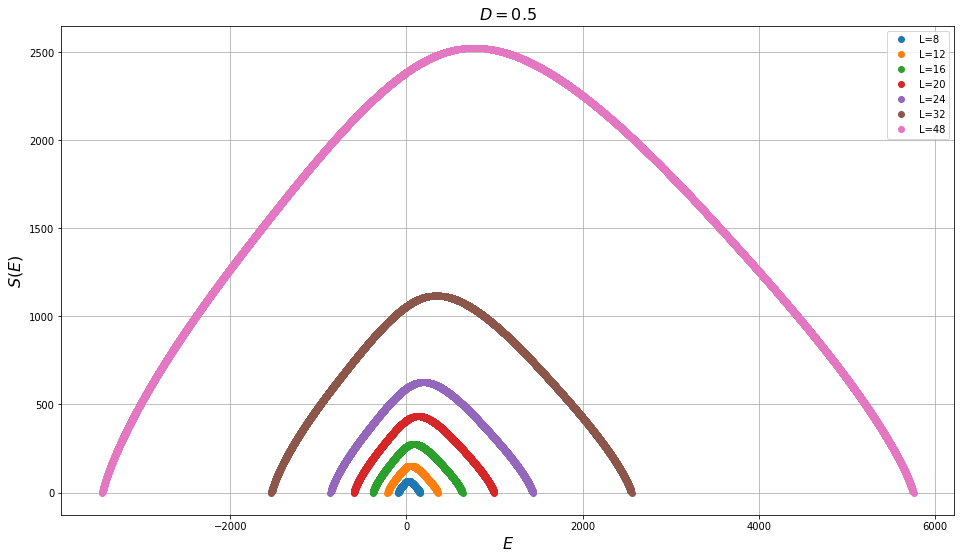

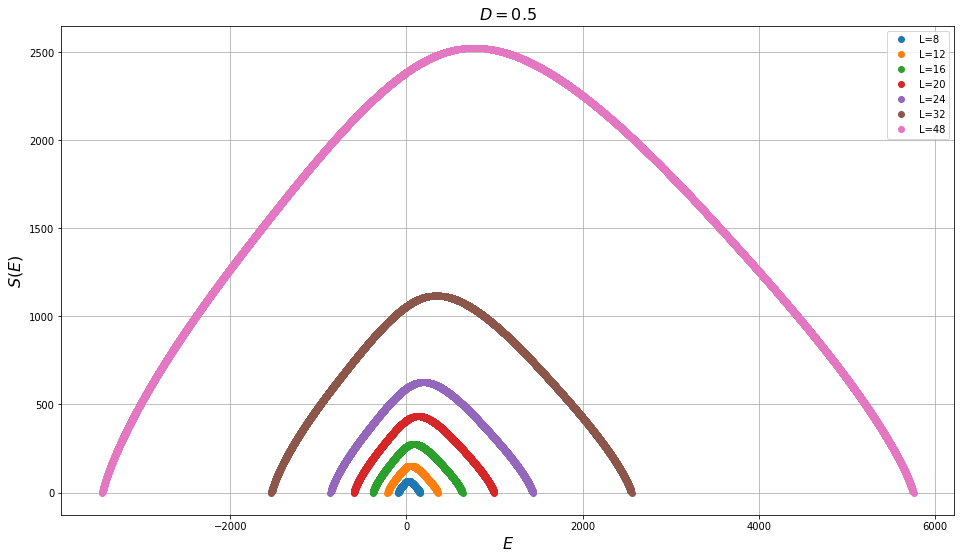

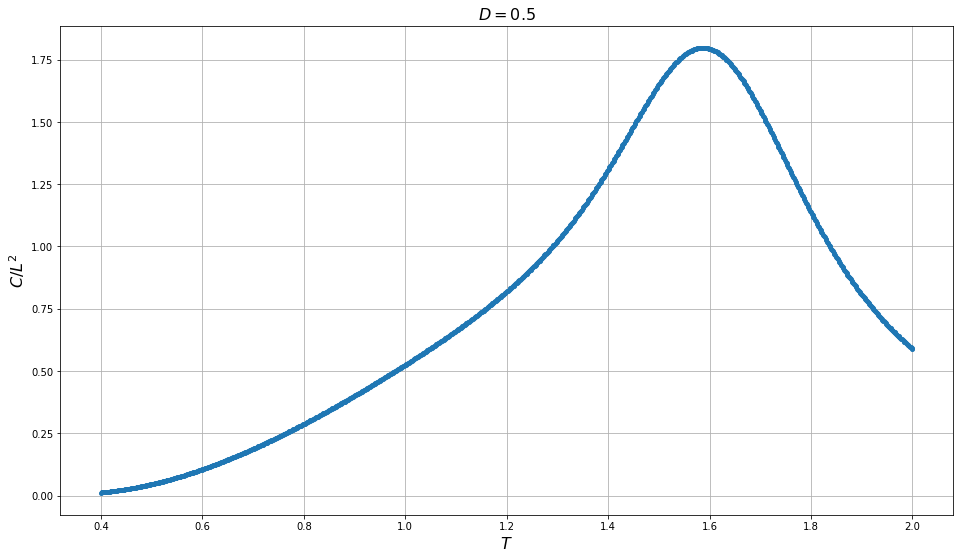

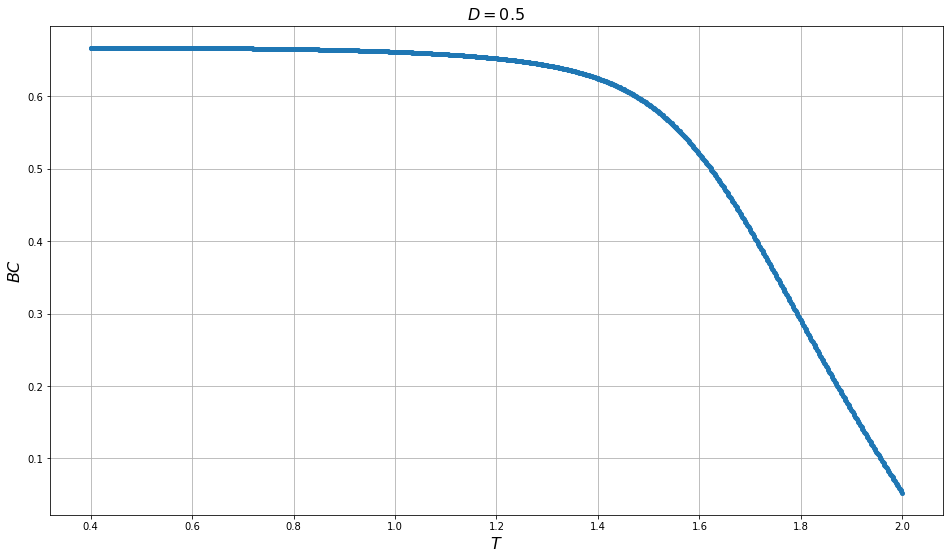

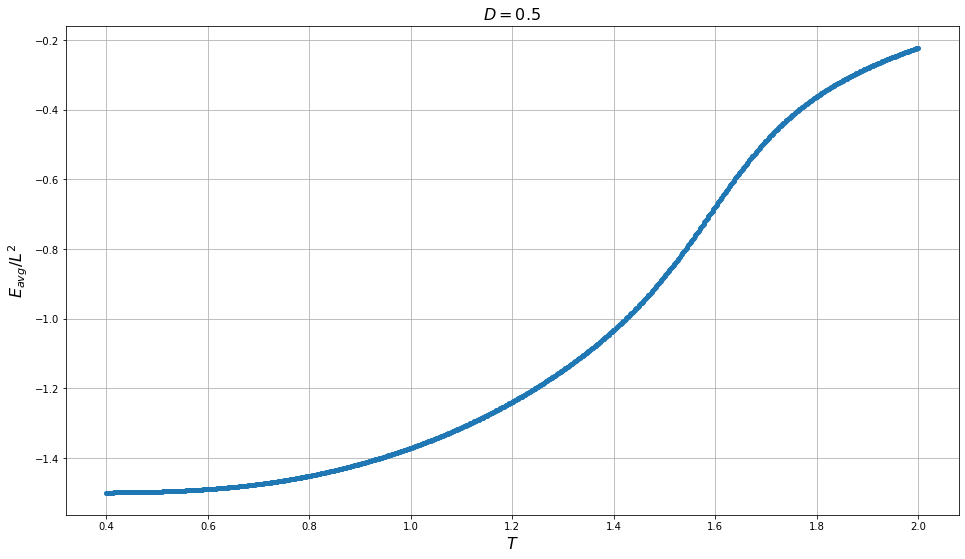

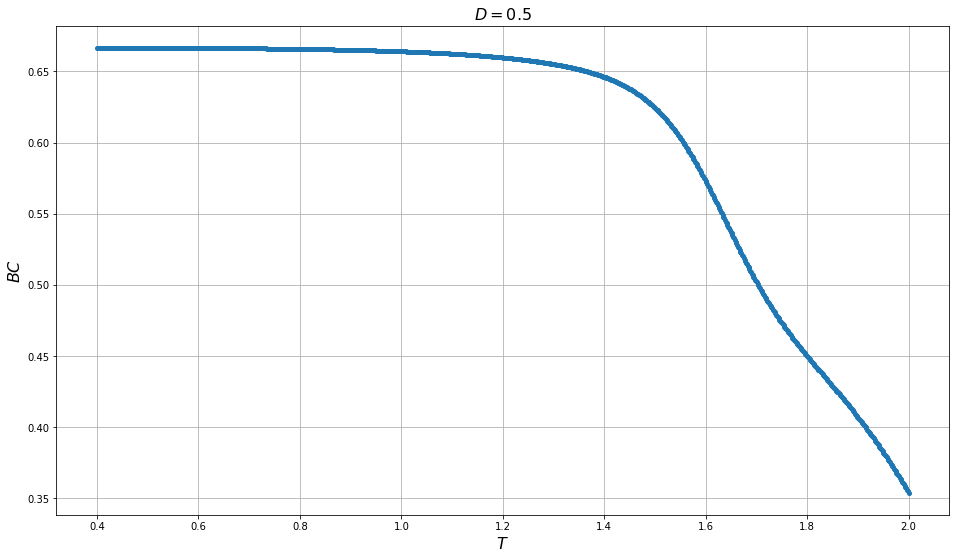

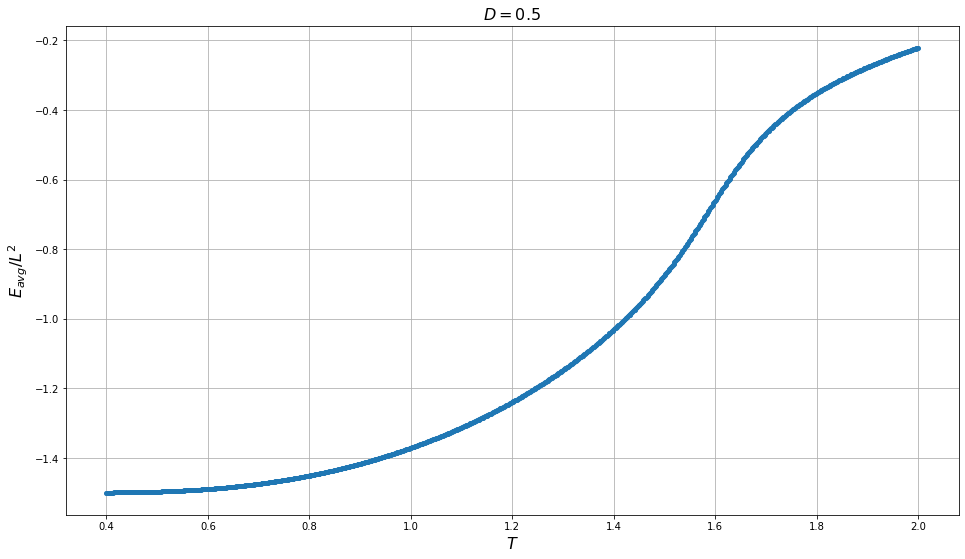

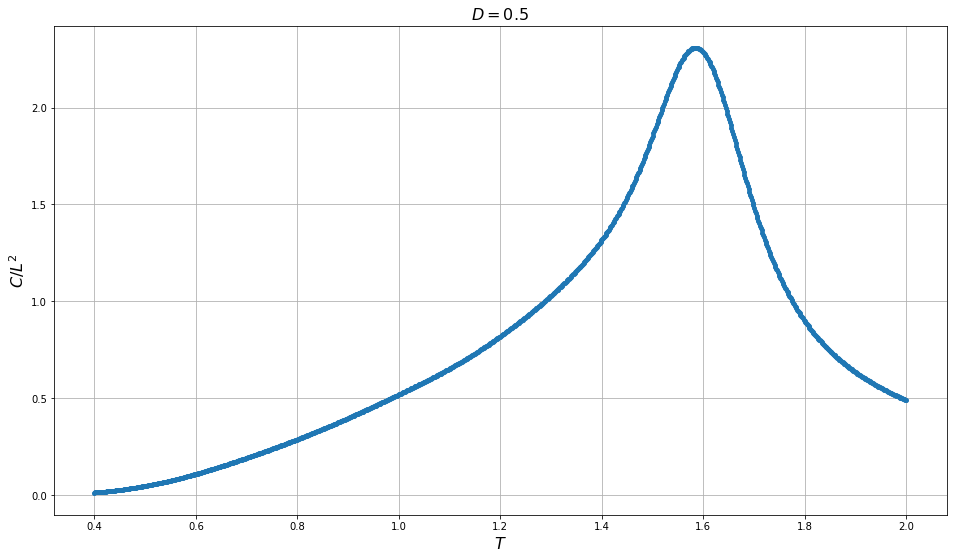

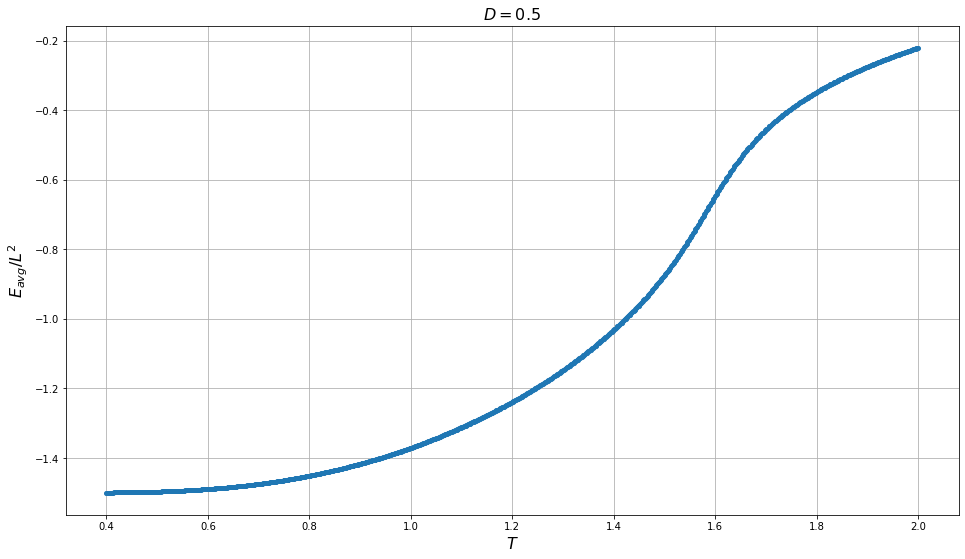

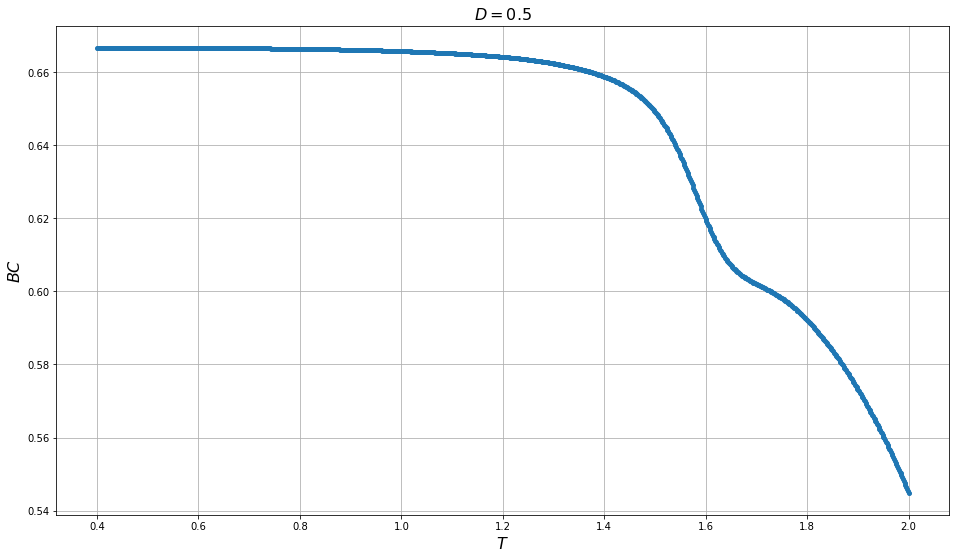

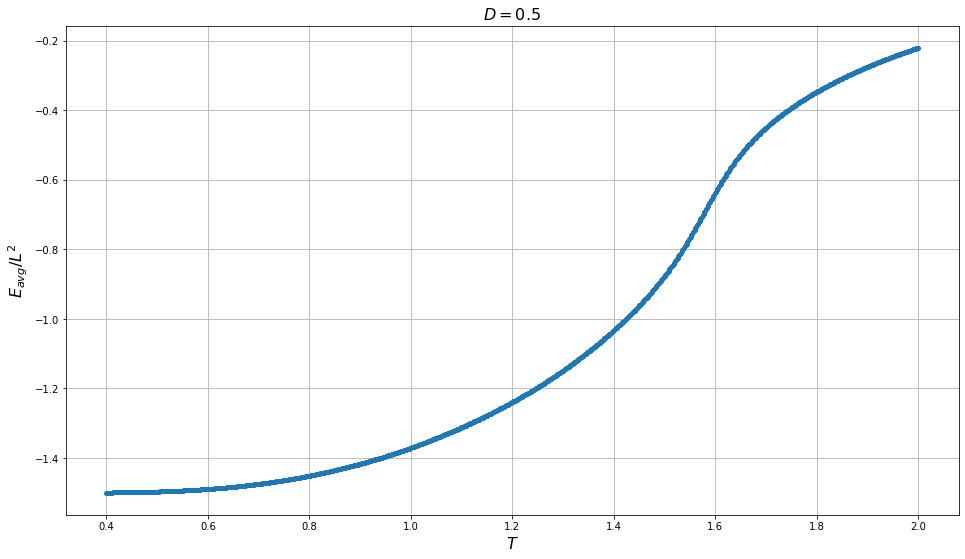

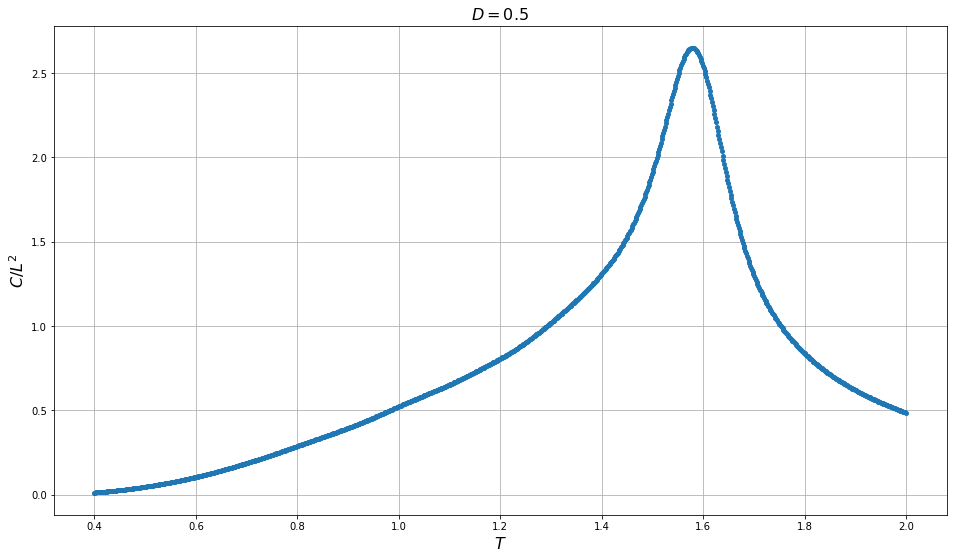

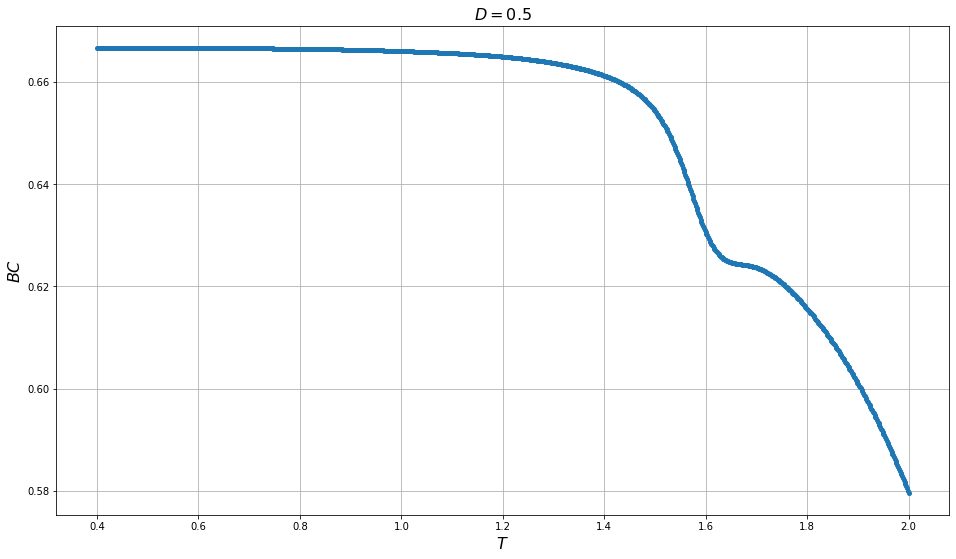

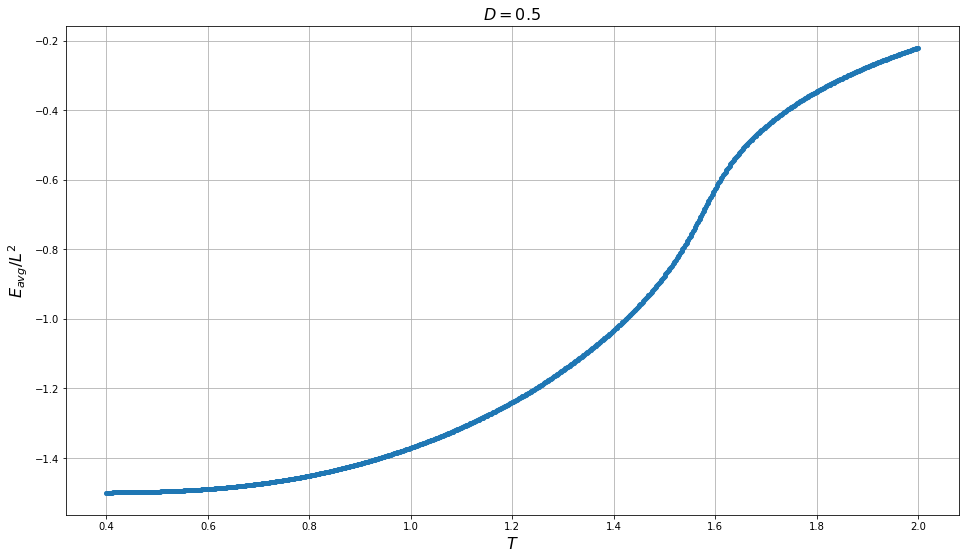

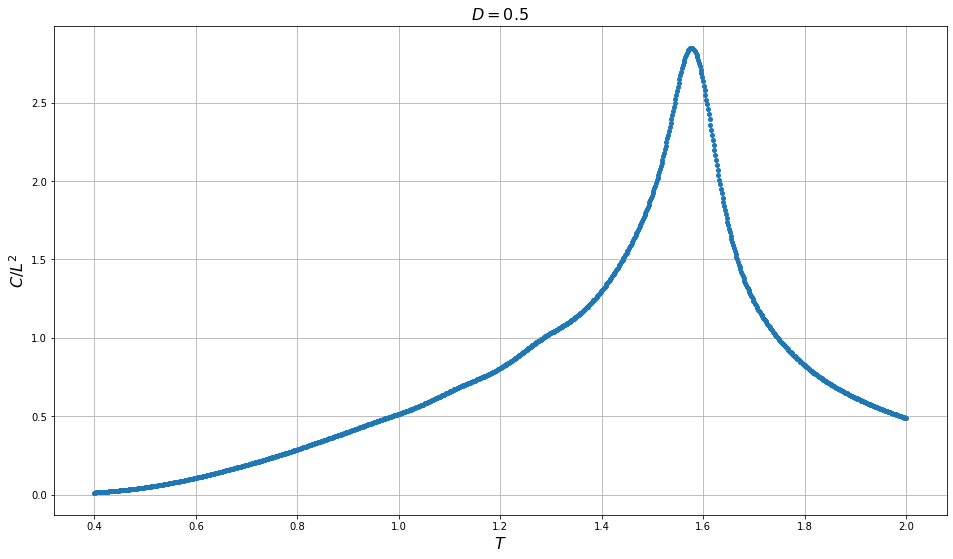

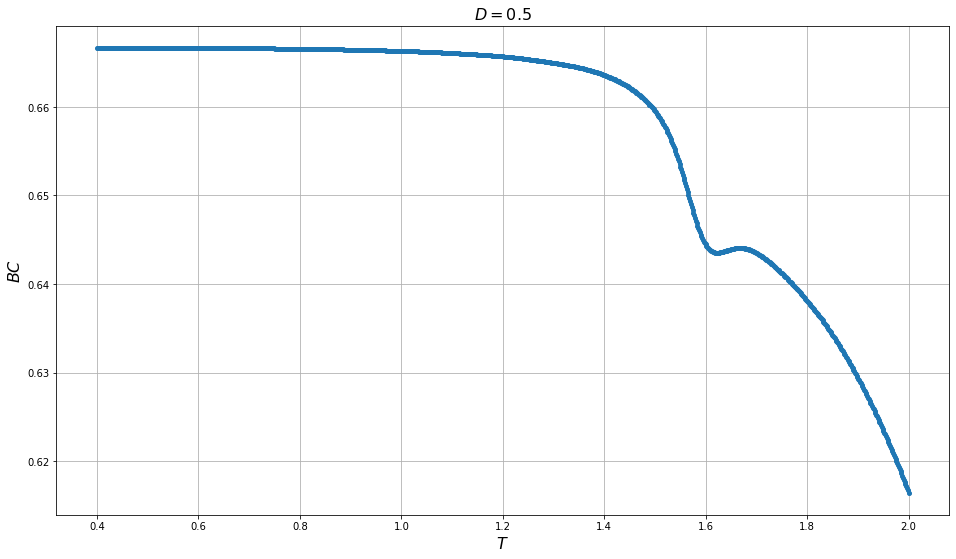

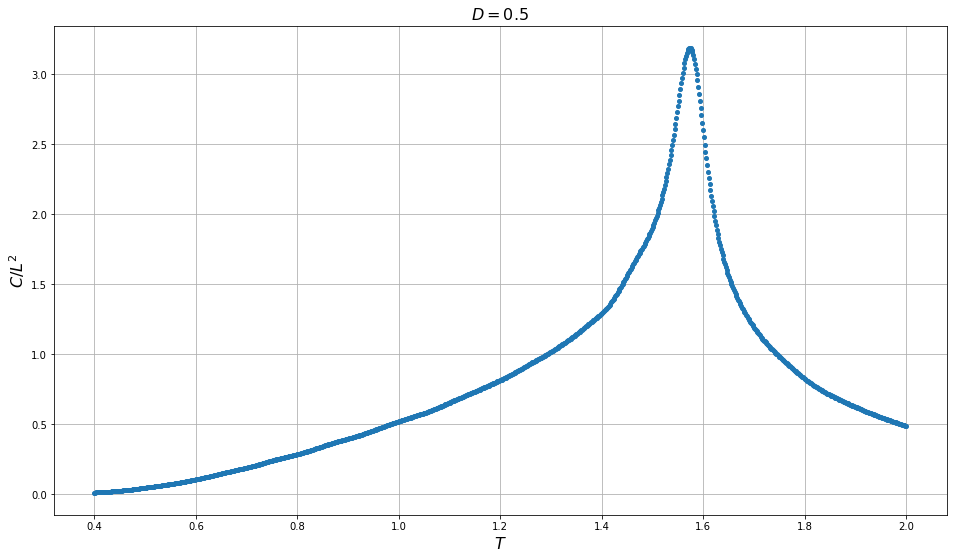

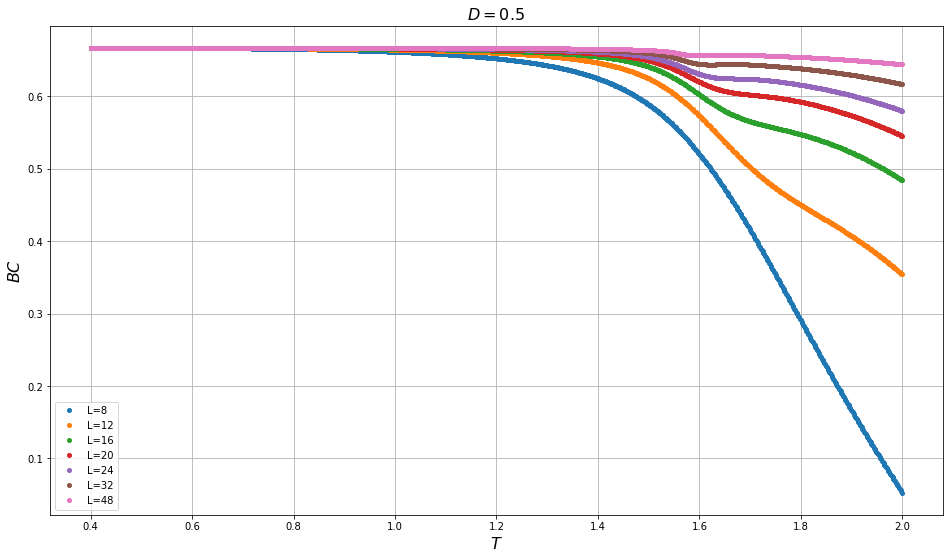

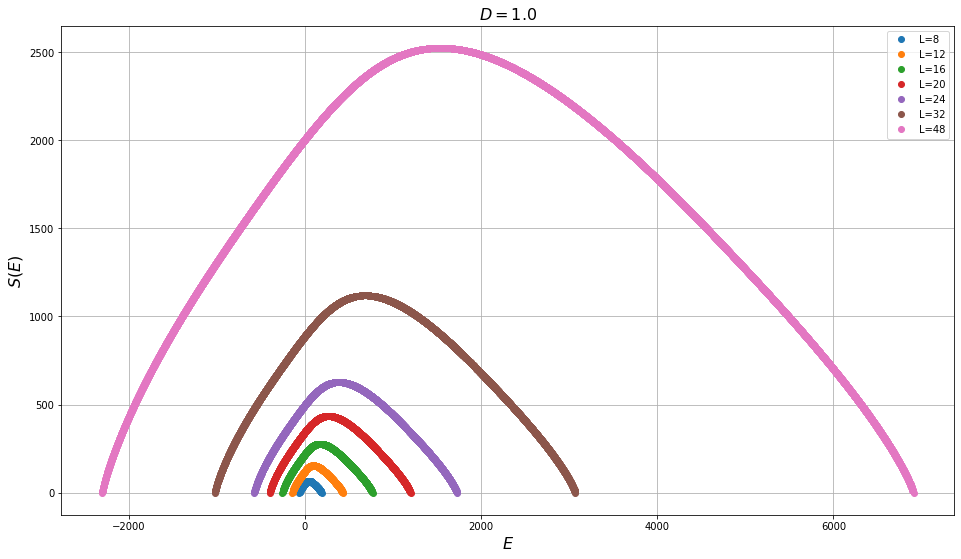

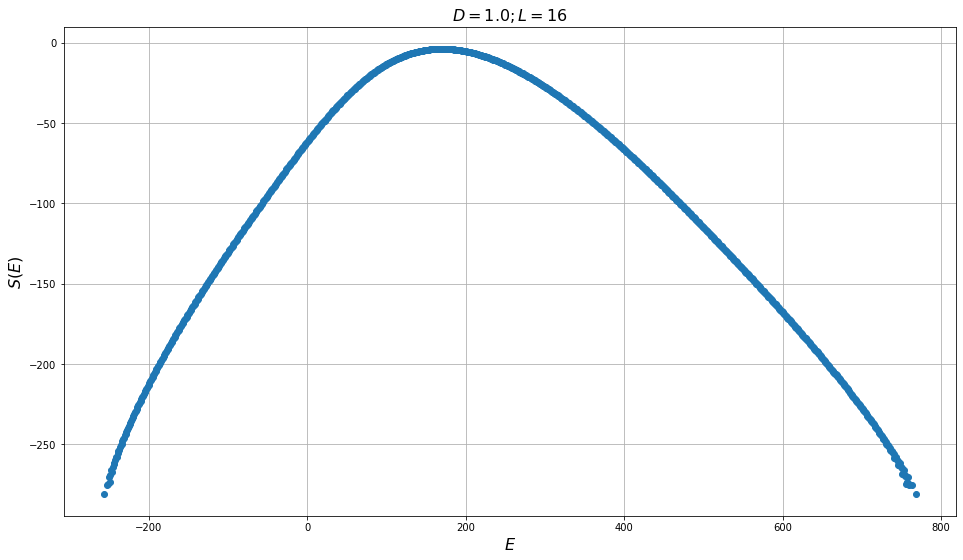

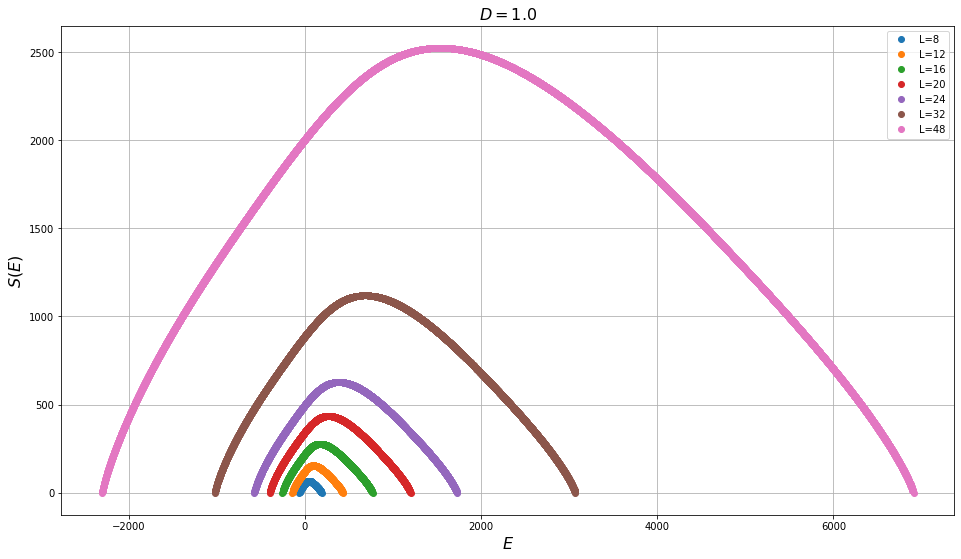

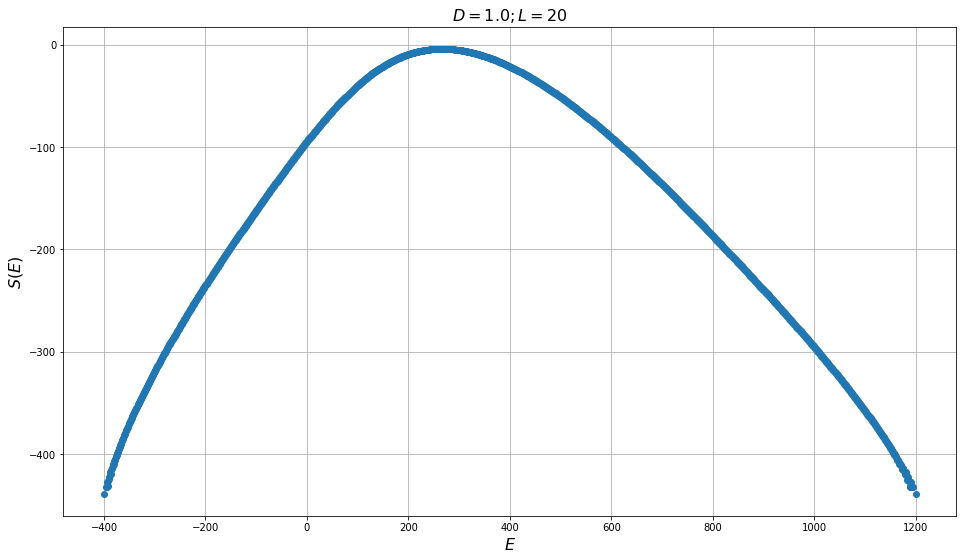

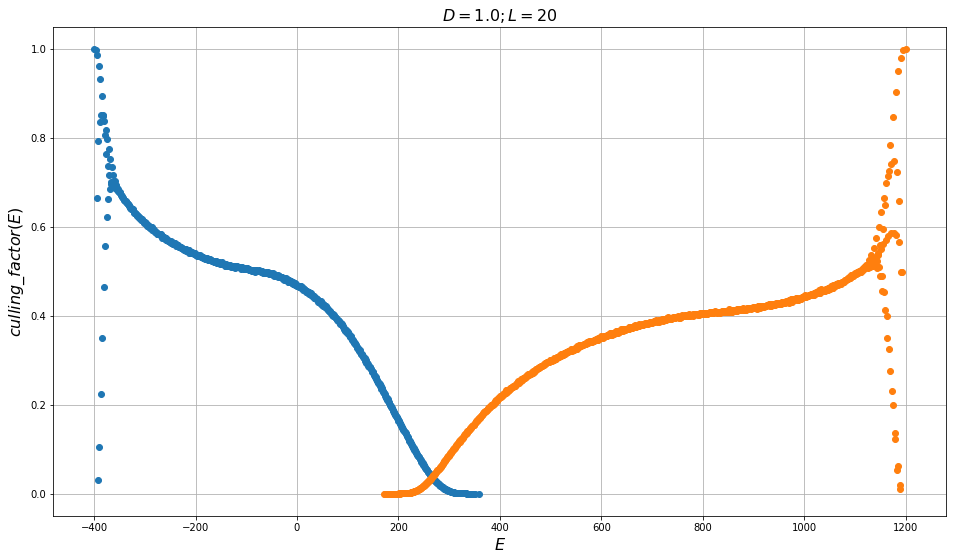

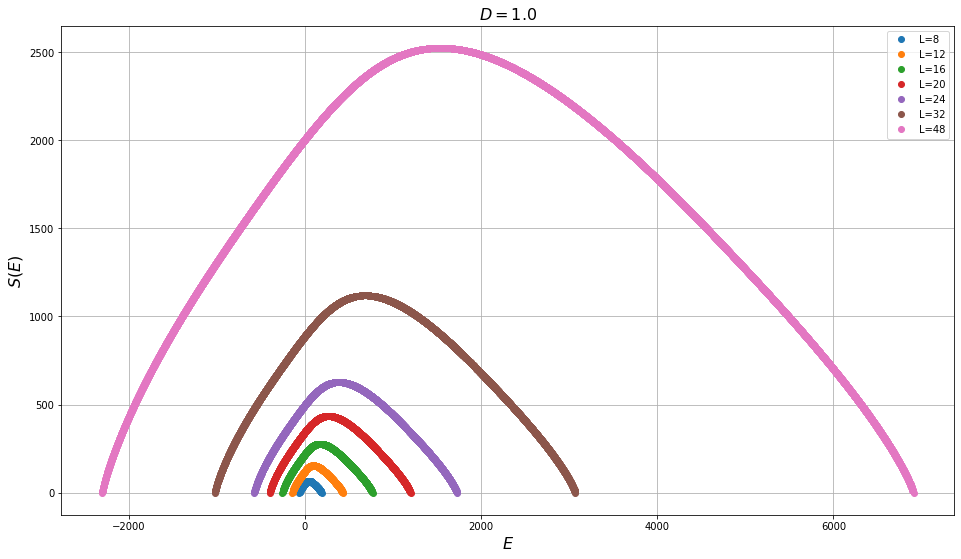

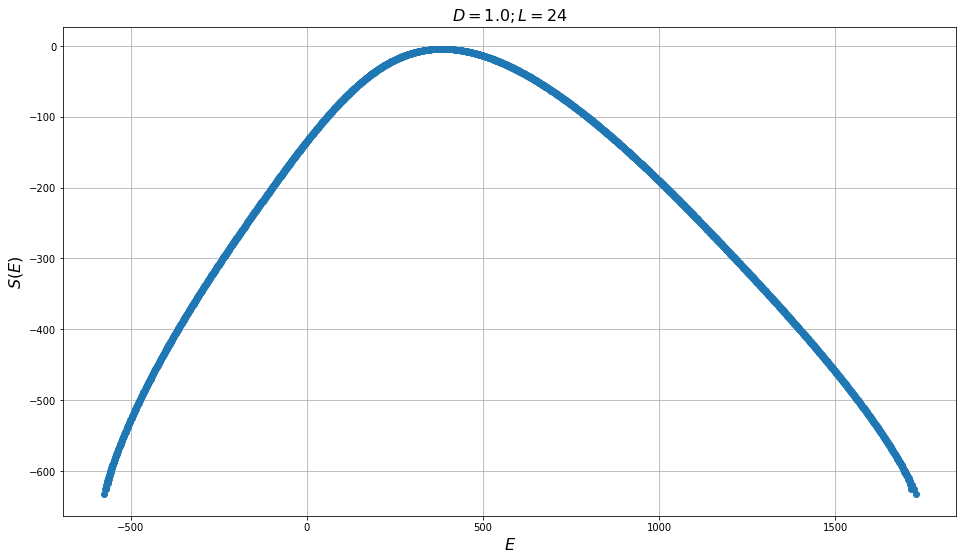

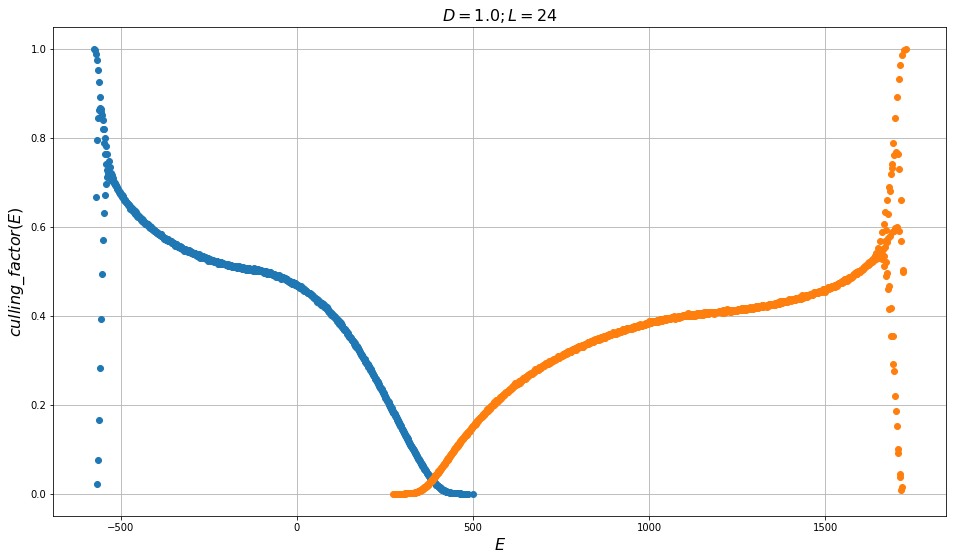

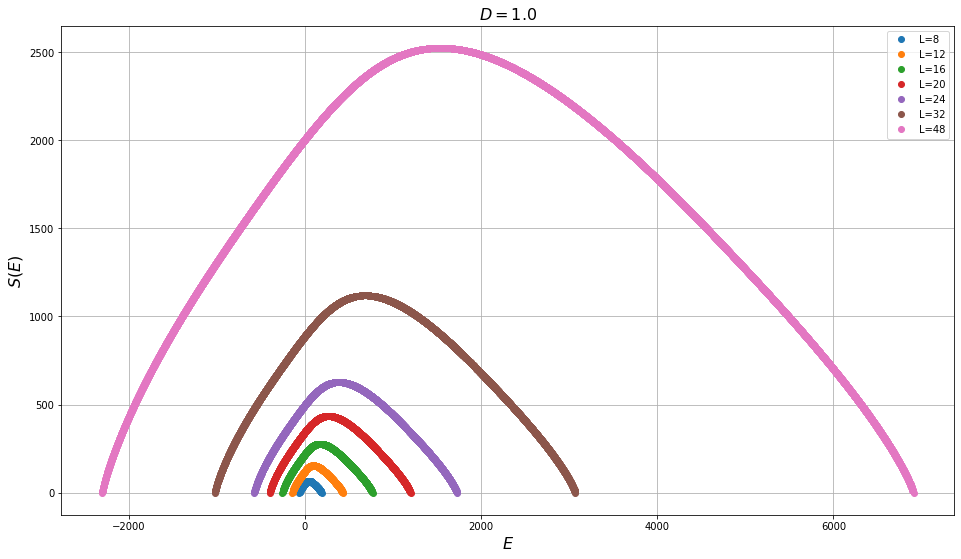

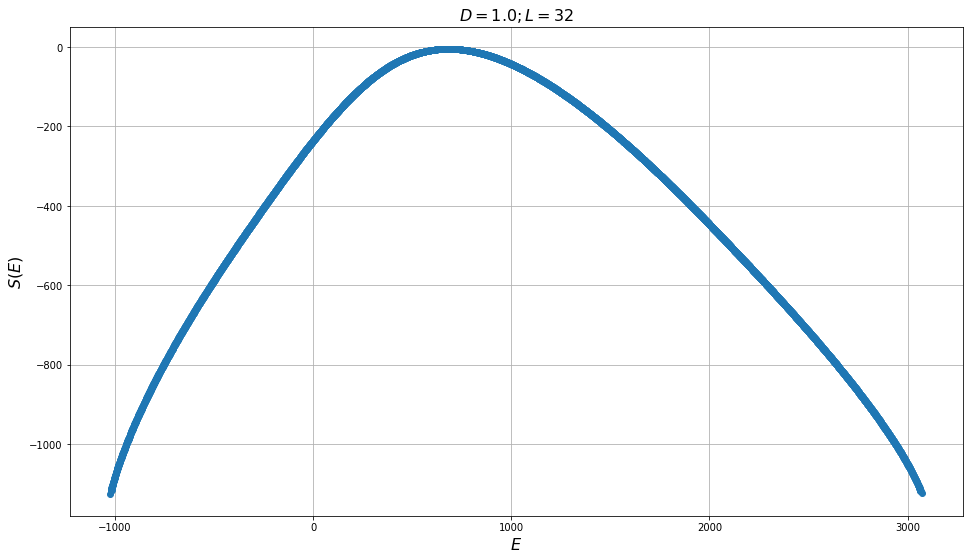

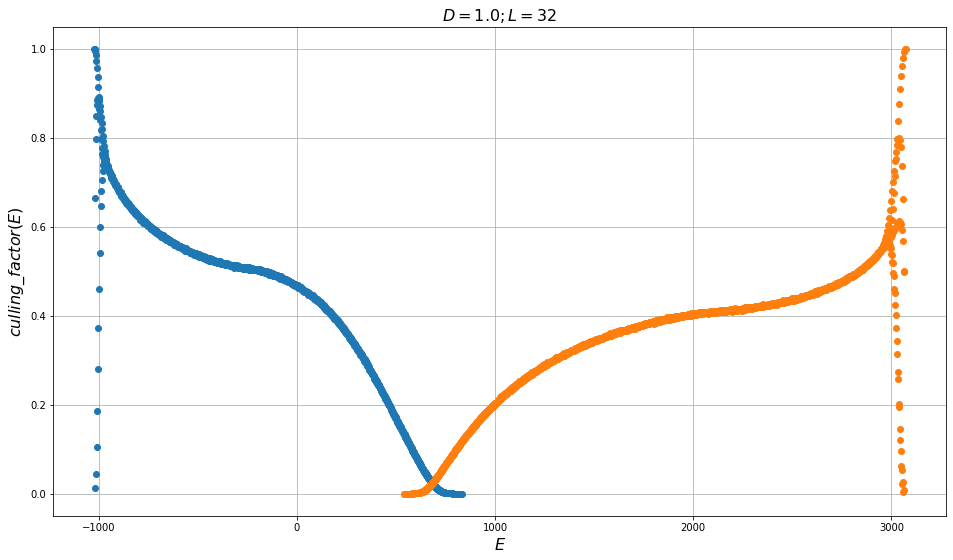

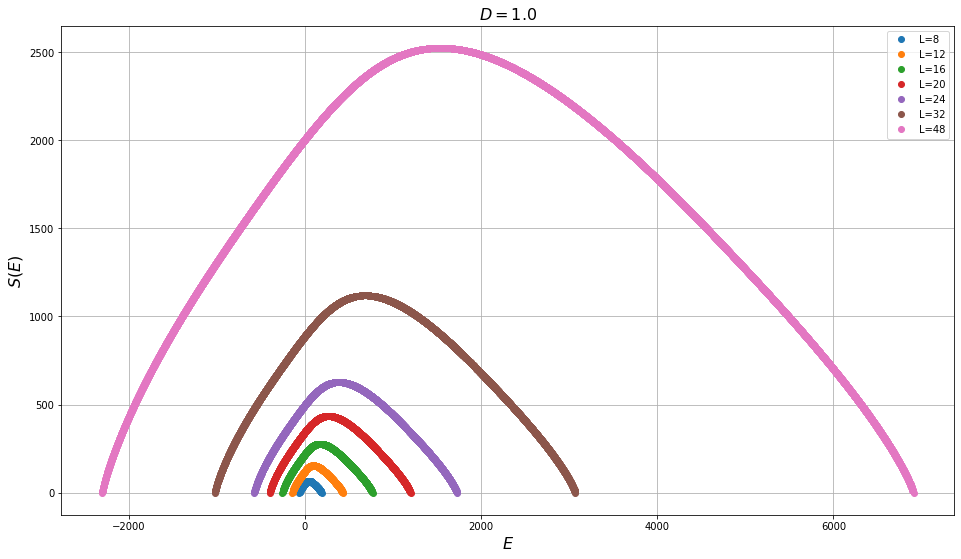

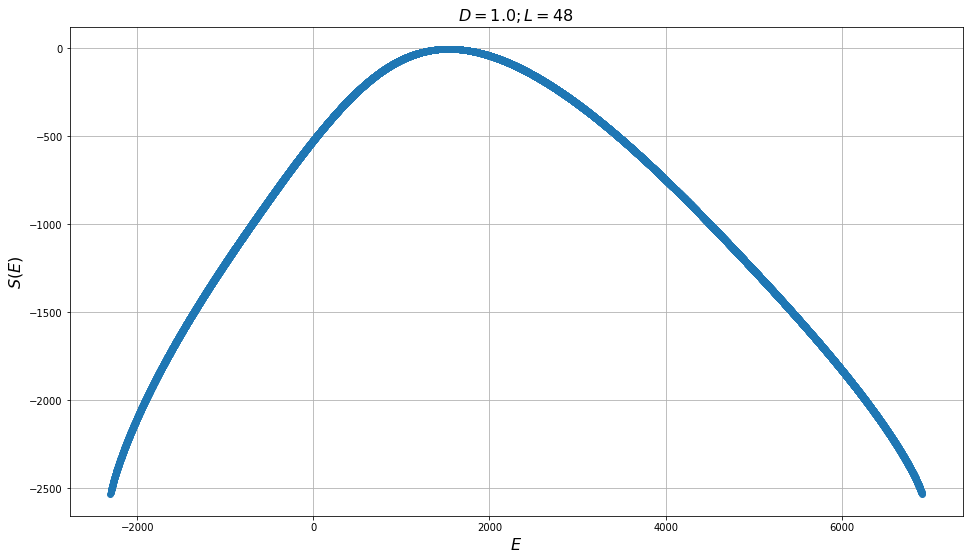

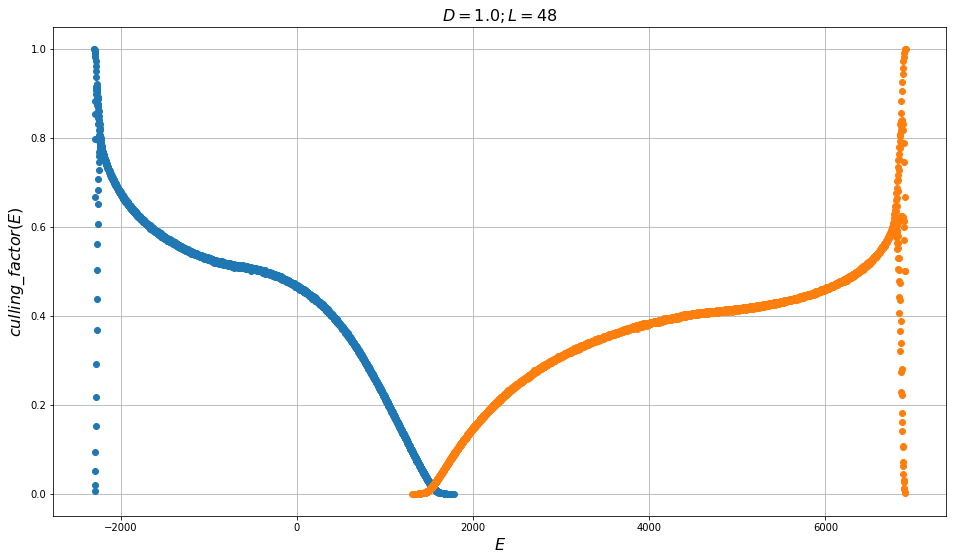

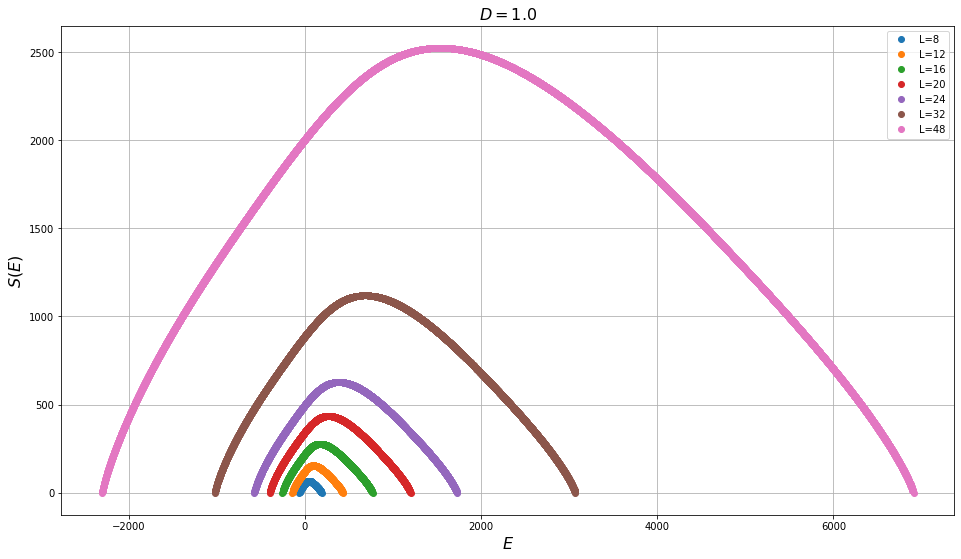

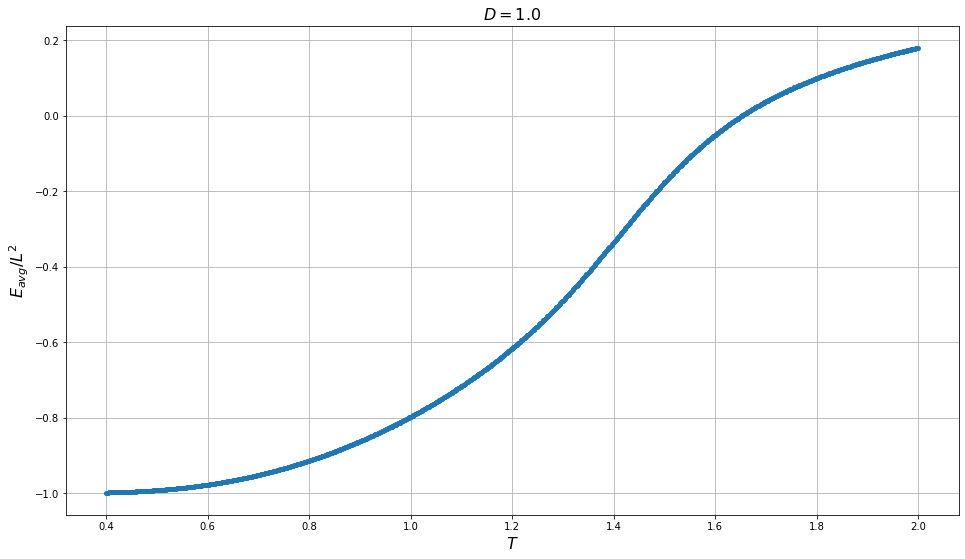

In [ ]:
for D in tqdm([0.0, 0.5, 1.0, 1.5, 1.75, 1.87, 1.9, 1.92, 1.95, 1.962, 1.99], desc="D"):
    
    L_list = [8, 12, 16, 20, 24, 32, 48]
    R_list = [#32768 if L == 96 else
        131072 for L in L_list]
    cool, heat = [{
        "q": 3,
        "D": D,
        "L": L,
        "R" : R,
        "nSteps" : 10,
        "seed" : 0,
        "heat": False
    } for L, R in zip(L_list, R_list)], [{
        "q": 3,
        "D": D,
        "L": L,
        "R" : R,
        "nSteps" : 10,
        "seed" : 0,
        "heat": True
    } for L, R in zip(L_list, R_list)]

    #print(D)
    parameters = []
    for x in zip(cool, heat):
        parameters.append(read_tuple_files(x))


    #plot S and culling factor
    for i, x in enumerate(tqdm(parameters, desc="L")):
        cool, heat, st = x['cool'], x['heat'], x['stitched']

        plt.figure(figsize=(16, 9))

        plt.plot([E for E in st['S']], [S for E, S in st['S'].items()], 'o')
        plt.grid()
        plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
        plt.ylabel('$S(E)$', fontsize=16)
        plt.xlabel('$E$', fontsize=16)
        plt.savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
        #plt.show()

        plt.figure(figsize=(16, 9))

        plt.plot([E for E in cool['culling_factor']], [c for E, c in cool['culling_factor'].items()], 'o')
        plt.plot([E for E in heat['culling_factor']], [c for E, c in heat['culling_factor'].items()], 'o')
        plt.grid()

        plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
        plt.ylabel('$culling\_factor(E)$', fontsize=16)
        plt.xlabel('$E$', fontsize=16)
        plt.savefig("./images/culling_factor(E)_D{}_L{}.png".format(st["D"], st["L"]))
        #plt.show()

        #plot co-plots of different L: S
        plt.figure(figsize=(16, 9))
        for i, x in enumerate(parameters):
            cool, heat, st = x['cool'], x['heat'], x['stitched']
            S_level = min(S for E, S in st['S'].items())
            plt.plot([E for E in st['S']], [S - S_level for E, S in st['S'].items()], 'o', label='L={}'.format(st["L"]))


        plt.grid()
        plt.title("$D={}$".format(st["D"]), fontsize=16)
        plt.ylabel('$S(E)$', fontsize=16)
        plt.xlabel('$E$', fontsize=16)
        plt.legend()
        plt.savefig("./images/S(E)_D{}.png".format(st["D"]))
        
        #plot heat capacity, E_avg and Binder Cummulant

    hc = {}
    E = {}
    BC = {}
    T_crit = {}

    for i, x in enumerate(tqdm(parameters, desc='over parameters')):
        st = parameters[i]["stitched"]
        L = st['L']
        N = L * L

        hc[L] = {}
        E[L] = {}
        BC[L] = {}


        #frames_list = list(zip(itertools.repeat(st), np.linspace(0.4, 2.0, 1000)))
        #with Pool(6) as p:
        #    pool_outputs = list(
        #            p.map(calc_hc_tpl, tqdm(frames_list, total=len(frames_list)))
        #    )

        # T, C, average E, BinderCumulant
        #for tpl in pool_outputs:
        #    T, x, y, z = tpl
        #    hc[L][T], E[L][T], BC[L][T] = x, y, z
        for T in tqdm(np.linspace(0.4, 2.0, 1000), desc='over temperature'):
            #T, C, average E, BinderCumulant
            _, hc[L][T], E[L][T], BC[L][T] = calc_hc(st, T)

        plt.figure(figsize=(16, 9))

        plt.plot([float(T) for T in E[st["L"]]], [float(E) / (L * L) for T, E in E[st["L"]].items()], 'o', markerSize = 4)
        plt.grid()
        plt.title("$D={}$".format(st["D"]), fontsize=16)
        plt.ylabel('$E_{avg} / L^2$', fontsize=16)
        plt.xlabel('$T$', fontsize=16)
        plt.savefig("./images/E_avg(T)_D{}_L{}.png".format(st["D"], st["L"]))


        plt.figure(figsize=(16, 9))

        plt.plot([float(T) for T in hc[st["L"]]], [float(C) / (L * L) for T, C in hc[st["L"]].items()], 'o', markerSize = 4)
        plt.grid()
        plt.title("$D={}$".format(st["D"]), fontsize=16)
        plt.ylabel('$C / L^2$', fontsize=16)
        plt.xlabel('$T$', fontsize=16)
        plt.savefig("./images/C(T)_D{}_L{}.png".format(st["D"], st["L"]))

        plt.figure(figsize=(16, 9))

        plt.plot([float(T) for T in BC[st["L"]]], [bc for T, bc in BC[st["L"]].items()], 'o', markerSize = 4)
        plt.grid()
        plt.title("$D={}$".format(st["D"]), fontsize=16)
        plt.ylabel('$BC$', fontsize=16)
        plt.xlabel('$T$', fontsize=16)
        plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))

        with open("./tmp/hc(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
            json.dump(hc, fp);
        with open("./tmp/E_avg(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
            json.dump(E, fp);
        with open("./tmp/BC(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
            json.dump(BC, fp);

        #print("calculated D{} L{}".format(st["D"], st["L"]), flush=True)
        
    #plot co-plots for heat capacity, E_avg and Binder Cummulant
    plt.figure(figsize=(16, 9))
    for i, x in enumerate(tqdm(parameters, desc='over parameters')):
        st = parameters[i]["stitched"]
        L = st['L']
        plt.plot([float(T) for T in E[L]], [float(E) / (L * L) for T, E in E[L].items()], 'o', markerSize = 4,
                 label='L={}'.format(st["L"]))

    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$E_{avg} / L^2$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.legend()
    plt.savefig("./images/E_avg(T)_D{}.png".format(st["D"]))

    #plot co-plots for heat capacity, E_avg and Binder Cummulant
    plt.figure(figsize=(16, 9))
    for i, x in enumerate(tqdm(parameters, desc='over parameters')):
        st = parameters[i]["stitched"]
        L = st['L']
        plt.plot([float(T) for T in hc[L]], [float(C) / (L * L) for T, C in hc[L].items()], 'o', markerSize = 4,
                 label='L={}'.format(L))
    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$C / L^2$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.legend()
    plt.savefig("./images/C(T)_D{}.png".format(st["D"]))

    #plot co-plots for heat capacity, E_avg and Binder Cummulant
    plt.figure(figsize=(16, 9))
    for i, x in enumerate(tqdm(parameters, desc='over parameters')):
        st = parameters[i]["stitched"]
        L = st['L']
        plt.plot([float(T) for T in BC[L]], [bc for T, bc in BC[L].items()], 'o', markerSize = 4,
                 label='L={}'.format(st["L"]))

    plt.grid()
    plt.title("$D={}$".format(st["D"]), fontsize=16)
    plt.ylabel('$BC$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.legend()
    plt.savefig("./images/BC(T)_D{}.png".format(st["D"]))

    
    
    for i, x in enumerate(tqdm(parameters, desc='over parameters')):
        st = x["stitched"]
        L = st["L"]
        a, b = keywithmaxval(hc[L]) - 0.1, keywithmaxval(hc[L]) + 0.1
        t, c, _, _ = fminbound(lambda T: -calc_hc(st, T)[1], a, b, maxfun=500, full_output=1, disp=False)
        T_crit[L] = {
            "T_crit": float(t),
            "C_crit": float(-c / (L * L))
        }
    with open("./tmp/T_crit_D{}.txt".format(D), 'w') as fp:
        json.dump(T_crit, fp)